In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle

In [2]:
class harmonic_oscillator:
    def __init__(self, k, mass, x0, u0):
        self.constant = -(k / mass)
        self.initial_conditions = np.array([x0, u0])

        #For analytical solutions
        self.A = np.sqrt(np.square(x0)+(np.square(u0)/(-self.constant)))
        self.omega = np.sqrt(-self.constant)
        self.phi = np.arctan2(x0/self.A, u0/(self.omega*self.A))
        self.period = 2*np.pi/self.omega
        self.energy = None

        #For saving data
        self.generated_points = None
        self.sampled_points = None
        self.dt_used_for_generation = None 
        self.t_final_used_for_generation = None 
        self.all_gradients = None 
    def calculate_coord_analyticaly(self, t):
        x = self.A * np.sin(self.omega*t+self.phi)
        u = self.A*self.omega* np.cos(self.omega*t+self.phi)
        return x, u
    def calculate_accelaration(self, x):
        return self.constant*x 
    def calculate_derivative(self, x, u):
        accelaration = self.calculate_accelaration(x)
        return np.array([u, accelaration])
    def move_interval(self, x, u, dt):
        step = self.calculate_derivative(x, u)*dt
        return np.array([x, u]) + step
    def generate_points(self, t_final, dt, analyticaly=False, save=False):
            points = []
            if t_final=='period':
                t_final=self.period
            time_points = np.arange(0, t_final + dt, dt) # This array now starts at 0

            if analyticaly==False:
                current_position = self.initial_conditions
                for time in time_points: # Iterate through the proper time points
                    points.append(np.array([current_position[0], current_position[1], time]))
                    current_position = self.move_interval(current_position[0], current_position[1], dt)
            else: # analyticaly==True
                for time in time_points: # Iterate through the proper time points
                    x, u = self.calculate_coord_analyticaly(time)
                    points.append(np.array([x, u, time]))
            
            if save == True:
                self.generated_points = points
                self.dt_used_for_generation = dt 
                self.t_final_used_for_generation = t_final
            return points
    def sample_points(self, sample_ratio, n_segments, random_segments=False, save=True):
        num_points = len(self.generated_points)
        num_samples_overall = int(num_points * sample_ratio)

        if n_segments <= 0:
            raise ValueError("n_segments must be a positive integer.")
        if num_samples_overall == 0:
            return []
        
        num_samples_per_segment = num_samples_overall // n_segments
        if num_samples_per_segment == 0:
            print(f"Warning: With {num_points} points, {sample_ratio} ratio, and {n_segments} segments, you'll get less than 1 sample per segment. Adjusting to sample 1 point from {num_samples_overall} segments.")
            num_samples_per_segment = 1
            n_segments = min(n_segments, num_samples_overall) # Adjust n_segments to actual samples

        segment_length = num_points // n_segments
        
        # Ensure we don't try to sample more points than available in a segment
        if num_samples_per_segment > segment_length:
            raise ValueError(f"num_samples_per_segment ({num_samples_per_segment}) is greater than "
                             f"the segment length ({segment_length}). Adjust sample_ratio or n_segments.")

        sampled_points = []
        
        if random_segments:
            for i in range(n_segments):
                # Define the bounds for choosing a center for this specific conceptual segment
                start_boundary = i * (num_points // n_segments)
                end_boundary = (i + 1) * (num_points // n_segments)
                
                # Adjust end_boundary for the last segment
                if i == n_segments - 1:
                    end_boundary = num_points


                
                valid_min_start_index = start_boundary
                valid_max_start_index = end_boundary - num_samples_per_segment
                
                if valid_min_start_index > valid_max_start_index:
                    # This segment is too small to fit the desired number of samples
                    # print(f"Warning: Segment {i} cannot fit {num_samples_per_segment} samples. Skipping or taking what's available.")
                    if end_boundary - start_boundary > 0:
                        # Take as many as possible if the segment has points
                        num_to_take = min(num_samples_per_segment, end_boundary - start_boundary)
                        start_idx = random.randint(start_boundary, end_boundary - num_to_take)
                        sampled_points.extend(self.generated_points[start_idx : start_idx + num_to_take])
                    continue # Skip to next segment

                random_start_index = random.randint(valid_min_start_index, valid_max_start_index)
                
                # Add points to the list
                sampled_points.extend(self.generated_points[random_start_index : random_start_index + num_samples_per_segment])

        else: # Equally separated segments
            step_between_segments = num_points // n_segments
            
            # Calculate the effective sample size to prevent index errors
            # if num_samples_per_segment is large relative to step_between_segments
            effective_sample_size = min(num_samples_per_segment, step_between_segments)

            for i in range(n_segments):
                segment_start_index = i * step_between_segments
                
                # Ensure we don't go out of bounds when taking consecutive points
                # The end index should not exceed num_points
                end_index_for_segment = min(segment_start_index + effective_sample_size, num_points)
                
                # If a segment is empty due to rounding, skip
                if segment_start_index >= end_index_for_segment:
                    continue

                sampled_points.extend(self.generated_points[segment_start_index : end_index_for_segment])
        

        if save==True:
            self.sampled_points=sampled_points[:num_samples_overall]
        return sampled_points[:num_samples_overall]


    def calculate_all_gradients(self, save=True):
        if self.generated_points is None:
            raise ValueError("No points generated yet. Call 'generate_points' first.")
        
        gradients = []
        for point in self.generated_points:
            x, u = point[0], point[1]
            gradient_vector = self.calculate_derivative(x, u)
            gradients.append(gradient_vector)
        
        if save:
            self.all_gradients = np.array(gradients)
        return np.array(gradients)
    




    def plot_points(self, show_sampled=False, show_derivative=False, show_generated=True):
        """
        Plot phase space trajectory (velocity vs position).
        
        Parameters:
        show_sampled: bool - If True, plot sampled points in a different color.
        show_derivative: bool - If True, plot gradient arrows at generated points.
        show_generated: bool - If True, plot all generated points.
        """
        if self.generated_points is None:
            raise ValueError("No points have been generated yet. Call 'generate_points' first.")
        
        # Retrieve dt and t_final from saved attributes
        dt = self.dt_used_for_generation
        t_final = self.t_final_used_for_generation

        # Convert generated_points to numpy array for easier handling
        gen_points_np = np.array(self.generated_points)
        x_gen = gen_points_np[:, 0]
        u_gen = gen_points_np[:, 1]
        time_gen = gen_points_np[:, 2]

        plt.figure(figsize=(10, 8))
        
        # Plot generated points if requested
        if show_generated:
            plt.plot(x_gen, u_gen, 'b-', linewidth=1.5, alpha=0.7, label='Generated Trajectory')
            # Changed from scatter to plot to remove time-based coloring by default
            plt.plot(x_gen, u_gen, 'bo', markersize=3, alpha=0.4, label='Generated Points') 
            
            # Highlight initial point
            plt.scatter(x_gen[0], u_gen[0], color='red', s=100, zorder=5, label=f'Initial point (t={time_gen[0]:.3f})')
            plt.annotate(f't = {time_gen[0]:.3f}', xy=(x_gen[0], u_gen[0]), xytext=(10, 10), textcoords='offset points',bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7),fontsize=10, color='white', weight='bold')
            
            # Highlight final point
            # Adjusting t_final_label for consistency with arange. 
            # If you modified generate_points to include t_final, this should be t_final.
            plt.scatter(x_gen[-1], u_gen[-1], color='orange', s=100, zorder=5, label=f'Final point (t={time_gen[-1]:.3f})') # <-- CHANGE HERE (use time_gen[-1])
            plt.annotate(f't = {time_gen[-1]:.3f}', xy=(x_gen[-1], u_gen[-1]), xytext=(-10, -20), textcoords='offset points',bbox=dict(boxstyle='round,pad=0.3', facecolor='orange', alpha=0.7),fontsize=10, color='white', weight='bold')
            
            # Add dt information as text box (if generated points are shown)
            plt.text(0.02, 0.98, f'dt = {dt}', transform=plt.gca().transAxes,bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),fontsize=11, verticalalignment='top')
            
            # Remove colorbar for time for generated points as requested.

        # Plot sampled points if requested
        if show_sampled:
            if self.sampled_points is None:
                raise ValueError("No points have been sampled yet. Call 'sample_points' first or ensure 'save=True'.")
            
            sampled_points_np = np.array(self.sampled_points)
            x_sampled = sampled_points_np[:, 0]
            u_sampled = sampled_points_np[:, 1]
            plt.scatter(x_sampled, u_sampled, color='red', marker='x', s=50, zorder=3, label='Sampled Points')

        # Plot derivatives (quiver plot) if requested
        if show_derivative:
            if self.all_gradients is None:
                raise ValueError("No gradients have been calculated yet. Call 'calculate_all_gradients' first or ensure 'save=True'.")
            
            gradients_np = self.all_gradients
            
            # The u and v components for quiver are the derivative values
            # u_vec is dx/dt (velocity), v_vec is du/dt (acceleration)
            u_vec = gradients_np[:, 0] 
            v_vec = gradients_np[:, 1]
            
            # Calculate magnitude for coloring
            magnitudes = np.sqrt(u_vec**2 + v_vec**2)
            
            # Use plt.quiver to plot arrows
            # scale_units='xy' and scale=1 makes arrows represent the actual magnitude in data units
            # angles='xy' ensures arrows point correctly in data coordinates
            quiv = plt.quiver(x_gen, u_gen, u_vec, v_vec, magnitudes, 
                              cmap='viridis', scale_units='xy', scale=None, alpha=0.7,
                              headwidth=4, headlength=6, pivot='middle', label='Gradients (Velocity, Acceleration)')
            plt.colorbar(quiv, label='Gradient Magnitude')


        plt.xlabel('Position (x)', fontsize=12)
        plt.ylabel('Velocity (u)', fontsize=12)
        plt.title(f'Phase Space Plot - Harmonic Oscillator', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()





        
class PhaseSpace:
    def __init__(self, k, mass):
        self.oscillators = []
        self.k = k
        self.mass = mass
        self.max_x0_param = None 
        self.max_u0_param = None 
        self.n_oscillators = None


        self.dt_used_for_phase_space_generation = None 
        self.t_final_used_for_phase_space_generation = None 

    def make_oscillators(self, n_oscillators, max_x0, max_u0, method, energy_min=0.001):
        self.oscillators = [] # Clear existing oscillators if called multiple times
        self.n_oscillators = n_oscillators
        self.max_x0_param = max_x0
        self.max_u0_param = max_u0

        if method == 'fully_random':
            for i in range(n_oscillators):
                # x0 can be positive or negative
                random_x0 = np.random.uniform(-max_x0, max_x0) 
                # u0 can be positive or negative
                random_u0 = np.random.uniform(-max_u0, max_u0)
                new_oscillator = harmonic_oscillator(k=self.k, mass=self.mass, x0=random_x0, u0=random_u0)
                self.oscillators.append(new_oscillator)

        elif method == 'random_energies':
            # Max energy defined by the corners of the phase space box
            max_energy_corner1 = 0.5 * (self.mass * (max_u0**2) + self.k * (max_x0**2))
            # Max energy considering only u0 (x0=0) or only x0 (u0=0)
            max_energy_u = 0.5 * self.mass * (max_u0**2)
            max_energy_x = 0.5 * self.k * (max_x0**2)
            max_energy = max(max_energy_corner1, max_energy_u, max_energy_x)

            for i in range(n_oscillators):
                random_energy = np.random.uniform(0.001, max_energy) # Ensure positive energy
                
                # For a given energy E, x must be within [-sqrt(2E/k), sqrt(2E/k)]
                x_limit_for_energy = np.sqrt(2 * random_energy / self.k)
                # Cap x0 to max_x0 parameter given
                actual_x0_limit = min(max_x0, x_limit_for_energy)

                # Randomly choose x0 within the allowed range for this energy AND max_x0
                random_x0 = np.random.uniform(-actual_x0_limit, actual_x0_limit)
                
                # Calculate u0 (can be positive or negative)
                # u^2 = (2E - kx^2) / m
                u_squared = (2 * random_energy - (self.k * (random_x0**2))) / self.mass
                
                # Ensure u_squared is not negative due to floating point inaccuracies
                u_squared = max(0, u_squared) 

                derived_u0_magnitude = np.sqrt(u_squared)
                
                # Randomly assign sign to u0
                derived_u0 = derived_u0_magnitude * np.random.choice([-1, 1])
                
                # Cap u0 to max_u0 parameter given
                if abs(derived_u0) > max_u0:
                    derived_u0 = np.sign(derived_u0) * max_u0

                new_oscillator = harmonic_oscillator(k=self.k, mass=self.mass, x0=random_x0, u0=derived_u0)
                self.oscillators.append(new_oscillator)

        elif method == 'stratified_energies':
            max_energy = 0.5 * (self.mass * (max_u0**2) + self.k * (max_x0**2))
            energy_min = energy_min 
            energy_interval = (max_energy - energy_min) / n_oscillators
            
            for i in range(n_oscillators):
                current_energy = energy_min + i * energy_interval
                
                x_limit_for_energy = np.sqrt(2 * current_energy / self.k)
                actual_x0_limit = min(max_x0, x_limit_for_energy)

                random_x0 = np.random.uniform(-actual_x0_limit, actual_x0_limit)
                
                u_squared = (2 * current_energy - (self.k * (random_x0**2))) / self.mass
                u_squared = max(0, u_squared)

                derived_u0_magnitude = np.sqrt(u_squared)
                derived_u0 = derived_u0_magnitude * np.random.choice([-1, 1])
                
                new_oscillator = harmonic_oscillator(k=self.k, mass=self.mass, x0=random_x0, u0=derived_u0)
                new_oscillator.energy = current_energy
                self.oscillators.append(new_oscillator)
        else:
            raise ValueError("Method must be 'fully_random', 'random_energies', or 'stratified_energies'.")
        
    def generate_all_oscillators_points(self, t_final, dt, analyticaly=False):
        if not self.oscillators:
            raise ValueError("No oscillators have been created yet. Call 'make_oscillators' first.")

        n_generated_points = 0
        for osc in self.oscillators:
            # Each oscillator generates and saves its own points
            osc.generate_points(t_final=t_final, dt=dt, analyticaly=analyticaly, save=True)
            n_generated_points += len(osc.generated_points)
        
        if t_final=='period':
            t_final=self.oscillators[0].period

        self.dt_used_for_phase_space_generation = dt
        self.t_final_used_for_phase_space_generation = t_final
        print(f"Generated a total of {n_generated_points} points")
        return None

    def calculate_all_oscillators_gradients(self):
        if not self.oscillators:
            raise ValueError("No oscillators have been created yet. Call 'make_oscillators' first.")
        
        if self.oscillators[0].generated_points is None:
            raise ValueError("No generated points for oscillators. Call 'generate_all_oscillators_points' first.")

        for osc in self.oscillators:
            osc.calculate_all_gradients(save=True) 
        
        return None
    
    def sample_all_oscillators_points(self, sample_ratio, n_segments, random_segments=False):
        if not self.oscillators:
            raise ValueError("No oscillators have been created yet. Call 'make_oscillators' first.")
        

        if self.oscillators[0].generated_points is None:
            raise ValueError("Generated points for all oscillators not found. Call 'generate_all_oscillators_points' first.")

        for osc in self.oscillators:
            osc.sample_points(sample_ratio=sample_ratio, n_segments=n_segments, random_segments=random_segments, save=True) 

        return None
    
    def make_trajectories_ids_df(self):
        if not self.oscillators:
            raise ValueError("No oscillators have been created yet. Call 'make_oscillators' first.")
        

        if self.oscillators[0].generated_points is None:
            raise ValueError("Generated points for all oscillators not found. Call 'generate_all_oscillators_points' first.")
        
        data = []
        start_index = np.int64(0)
        for i, osc in enumerate(self.oscillators):
            x0, u0 = osc.initial_conditions  # unpack np.array([x0, u0])
            energy = osc.energy
            number_of_points = np.int64(len(osc.generated_points))
            data.append({"trajectory_id":i, "x0": x0, "u0": u0, "energy": energy, "generated_points": np.int64(number_of_points), "start_index":np.int64(start_index), "end_index":start_index+number_of_points})
            start_index += number_of_points
        df = pd.DataFrame(data)
        df = df.astype({"generated_points": "int64", "start_index": "int64", "end_index": "int64"})
        return df


    def make_trajectories_df(self):
        if not self.oscillators:
            raise ValueError("No oscillators have been created yet. Call 'make_oscillators' first.")
        

        if self.oscillators[0].generated_points is None:
            raise ValueError("Generated points for all oscillators not found. Call 'generate_all_oscillators_points' first.")
        
        data = []

        for osc in self.oscillators:
            for point in osc.generated_points:
                data.append({"x": point[0], "u": point[1], "t": point[2]})
        df = pd.DataFrame(data)
        return df


    def plot_phase_space(self, show_sampled=False, show_derivative=False, show_generated=True, plot_limits=None):
        """
        Plots the phase space of all oscillators.
        
        Parameters:
        show_sampled: bool - If True, plots the sampled points.
        show_derivative: bool - If True, plots the gradient arrows.
        show_generated: bool - If True, plots all generated points/trajectories.
        plot_limits: tuple or None - (xmin, xmax, ymin, ymax) to set explicit plot limits.
        """
        if not self.oscillators:
            raise ValueError("No oscillators have been created yet. Call 'make_oscillators' first.")
        
        plt.figure(figsize=(10, 8))

        # Retrieve dt and t_final from saved attributes for plot title
        dt = self.dt_used_for_phase_space_generation
        t_final = self.t_final_used_for_phase_space_generation

        # Plot generated points/trajectories
        if show_generated:
            if self.oscillators[0].generated_points is None:
                raise ValueError("No points generated for all oscillators. Call 'generate_all_oscillators_points' first.")
            
            all_initial_x = []
            all_initial_u = []



            for i, osc in enumerate(self.oscillators):
                gen_points_np = np.array(osc.generated_points)
                x_gen = gen_points_np[:, 0]
                u_gen = gen_points_np[:, 1]
                
                plt.plot(x_gen, u_gen, alpha=0.6, linewidth=0.8, color='blue', label=f'Oscillator {i+1} Trajectory' if len(self.oscillators) <= 5 else "_nolegend_")
                all_initial_x.append(x_gen[0])
                all_initial_u.append(u_gen[0])
            
            # Plot all initial points together for clarity, regardless of n_oscillators
            plt.scatter(all_initial_x, all_initial_u, color='red', marker='o', s=20, alpha=0.6, label='Initial Conditions')
            
            # Add a single label for the trajectories if there are many
            if self.n_oscillators > 5:
                plt.plot([], [], 'b-', alpha=0.6, linewidth=0.8, label='Trajectories')


        # Plot sampled points
        if show_sampled:
            # Check if at least one oscillator has sampled points
            if self.oscillators[0].sampled_points is None:
                raise ValueError("No points sampled for oscillators. Call 'sample_all_oscillators_points' first.")
            
            all_sampled_x = []
            all_sampled_u = []
            for osc in self.oscillators:
                if osc.sampled_points is not None: # Only add if this oscillator has sampled points
                    sampled_points_np = np.array(osc.sampled_points)
                    all_sampled_x.extend(sampled_points_np[:, 0])
                    all_sampled_u.extend(sampled_points_np[:, 1])
            
            if all_sampled_x: # Only plot if there are actual sampled points
                plt.scatter(all_sampled_x, all_sampled_u, color='purple', marker='x', s=50, zorder=3, label='Sampled Points')

        # Plot derivatives (quiver plot)
        if show_derivative:
            # Check if at least one oscillator has gradients calculated
            if self.oscillators[0].all_gradients is None:
                raise ValueError("No gradients calculated for oscillators. Call 'calculate_all_oscillators_gradients' first.")
            
            all_quiver_x = []
            all_quiver_u = []
            all_u_vec = []
            all_v_vec = []

            for osc in self.oscillators:
                if osc.all_gradients is not None and osc.generated_points is not None:
                    gen_points_np = np.array(osc.generated_points)
                    gradients_np = osc.all_gradients # Assumed to be numpy array already from osc.calculate_all_gradients

                    all_quiver_x.extend(gen_points_np[:, 0])
                    all_quiver_u.extend(gen_points_np[:, 1])
                    all_u_vec.extend(gradients_np[:, 0])
                    all_v_vec.extend(gradients_np[:, 1])
            
            if all_quiver_x: # Only plot if there are actual gradients
                all_quiver_x_np = np.array(all_quiver_x)
                all_quiver_u_np = np.array(all_quiver_u)
                all_u_vec_np = np.array(all_u_vec)
                all_v_vec_np = np.array(all_v_vec)

                magnitudes = np.sqrt(all_u_vec_np**2 + all_v_vec_np**2)
                
                quiv = plt.quiver(all_quiver_x_np, all_quiver_u_np, all_u_vec_np, all_v_vec_np, magnitudes, 
                                  cmap='viridis', scale_units='xy', scale=None, alpha=0.7,
                                  headwidth=4, headlength=6, pivot='middle', label='Gradients')
                plt.colorbar(quiv, label='Gradient Magnitude')

        plt.xlabel('Position (x)', fontsize=12)
        plt.ylabel('Velocity (u)', fontsize=12)
        
        title_suffix = ""
        if dt is not None and t_final is not None:
            title_suffix = f" (t_final={t_final}, dt={dt})"
        plt.title(f'Phase Space of {self.n_oscillators} Harmonic Oscillators{title_suffix}', fontsize=14)
        
        plt.grid(True, alpha=0.3)
        plt.legend()

        if plot_limits:
            plt.xlim(plot_limits[0], plot_limits[1])
            plt.ylim(plot_limits[2], plot_limits[3])
        elif self.max_x0_param is not None and self.max_u0_param is not None:
             # Use the max_x0, max_u0 used to make oscillators with a slightly larger buffer
             plt.xlim(-self.max_x0_param * 1.5, self.max_x0_param * 1.5)
             plt.ylim(-self.max_u0_param * 1.5, self.max_u0_param * 1.5)

        plt.tight_layout()
        plt.show()
        
    
    


In [3]:
test_oscilaltor = harmonic_oscillator(mass=1, k=1, x0=1.0, u0=0.0)

In [4]:
test_oscilaltor.generate_points(t_final=20.0, dt=0.20943951023931953, analyticaly=True, save=True)

[array([1.000000e+00, 6.123234e-17, 0.000000e+00]),
 array([ 0.9781476 , -0.20791169,  0.20943951]),
 array([ 0.91354546, -0.40673664,  0.41887902]),
 array([ 0.80901699, -0.58778525,  0.62831853]),
 array([ 0.66913061, -0.74314483,  0.83775804]),
 array([ 0.5       , -0.8660254 ,  1.04719755]),
 array([ 0.30901699, -0.95105652,  1.25663706]),
 array([ 0.10452846, -0.9945219 ,  1.46607657]),
 array([-0.10452846, -0.9945219 ,  1.67551608]),
 array([-0.30901699, -0.95105652,  1.88495559]),
 array([-0.5      , -0.8660254,  2.0943951]),
 array([-0.66913061, -0.74314483,  2.30383461]),
 array([-0.80901699, -0.58778525,  2.51327412]),
 array([-0.91354546, -0.40673664,  2.72271363]),
 array([-0.9781476 , -0.20791169,  2.93215314]),
 array([-1.00000000e+00, -1.83697020e-16,  3.14159265e+00]),
 array([-0.9781476 ,  0.20791169,  3.35103216]),
 array([-0.91354546,  0.40673664,  3.56047167]),
 array([-0.80901699,  0.58778525,  3.76991118]),
 array([-0.66913061,  0.74314483,  3.97935069]),
 array([

In [11]:
        
data = []

for point in test_oscilaltor.generated_points:
    data.append({"x": point[0], "u": point[1], "t": point[2]})
hnn_test_traj_data_df = pd.DataFrame(data)


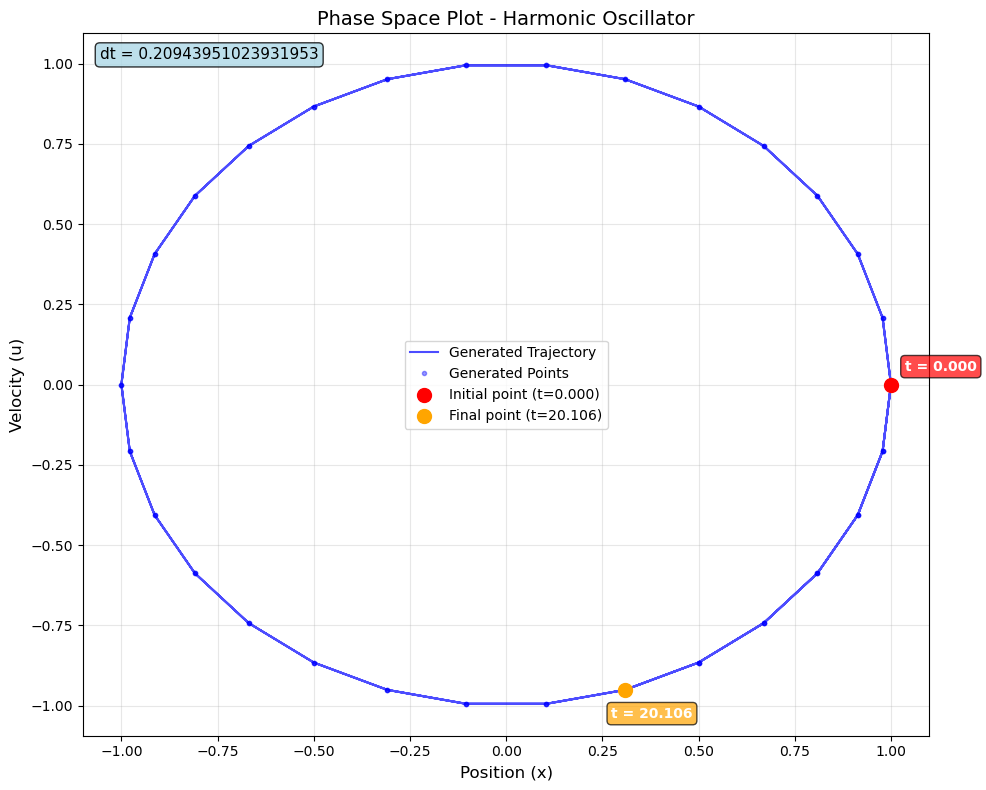

In [7]:
test_oscilaltor.plot_points(show_sampled=False, show_derivative=False, show_generated=True)

In [16]:
x0, u0 = test_oscilaltor.initial_conditions  # unpack np.array([x0, u0])
energy = 1.0
number_of_points = np.int64(len(test_oscilaltor.generated_points))
start_index = 0

data = {
    "trajectory_id": 1, 
    "x0": x0, 
    "u0": u0, 
    "energy": energy, 
    "generated_points": np.int64(number_of_points), 
    "start_index": np.int64(start_index), 
    "end_index": start_index + number_of_points
}

hnn_test_traj_data_id_df = pd.DataFrame(data, index=[0])  # Provide explicit index
hnn_test_traj_data_id_df = hnn_test_traj_data_id_df.astype({"generated_points": "int64", "start_index": "int64", "end_index": "int64"})

In [20]:


# Put all DataFrames into a dictionary
dfs_test_traj = {
    "data_df_test_traj": hnn_test_traj_data_df,
    "id_df_test_traj": hnn_test_traj_data_id_df,
}

# Save everything in one file
with open("all_dataframes_test_traj.pkl", "wb") as f:
    pickle.dump(dfs_test_traj, f)

print("✅ All DataFrames saved to all_dataframes_test_traj.pkl")

✅ All DataFrames saved to all_dataframes_test_traj.pkl


In [3]:

def split_trajectories(ids_df, full_df, val_pct=0.1, test_pct=0.1, random_state=42, bins=10):
    """
    Split oscillator trajectories into train/val/test sets, stratified by energy.

    Args:
        ids_df (pd.DataFrame): Output of make_trajectories_ids_df (one row per oscillator).
        full_df (pd.DataFrame): Output of make_trajectories_df (all trajectory points).
        val_pct (float): Fraction of oscillators to use for validation.
        test_pct (float): Fraction of oscillators to use for test.
        random_state (int): Random seed for reproducibility.
        bins (int): Number of bins to discretize energy for stratification.

    Returns:
        (train_df, val_df, test_df,
         train_id_df, val_id_df, test_id_df)
    """
    # copy to avoid modifying original
    ids_df = ids_df.copy()
    ids_df["energy_bin"] = pd.qcut(ids_df["energy"], q=bins, duplicates="drop")

    # split test first
    train_val_ids, test_id_df = train_test_split(
        ids_df,
        test_size=test_pct,
        stratify=ids_df["energy_bin"],
        random_state=random_state
    )

    # then split val from remaining
    train_id_df, val_id_df = train_test_split(
        train_val_ids,
        test_size=val_pct / (1 - test_pct),  # adjust relative size
        stratify=train_val_ids["energy_bin"],
        random_state=random_state
    )

    # clean up temporary column
    for df in (train_id_df, val_id_df, test_id_df):
        df.drop(columns=["energy_bin"], inplace=True)

    # --- build point-level splits ---
    def gather_points(sub_ids):
        mask = pd.Series(False, index=full_df.index)
        for _, row in sub_ids.iterrows():
            mask.loc[row["start_index"]:row["end_index"]-1] = True
        return full_df[mask]

    train_df = gather_points(train_id_df)
    val_df   = gather_points(val_id_df)
    test_df  = gather_points(test_id_df)

    return train_df, val_df, test_df, train_id_df, val_id_df, test_id_df


In [4]:
points_per_trajectory_number_of_different_trajectories_ratio = 2
samples_per_period = 60
periods_per_trajectory = 4
k=1
mass=1
constant = -(k / mass)
omega = np.sqrt(-constant)
period = 2*np.pi/omega
dt = period/samples_per_period
Tmax = periods_per_trajectory*period
points_per_trajectory = int(round(Tmax / dt)) + 2
n_tajectories = round(points_per_trajectory/points_per_trajectory_number_of_different_trajectories_ratio)
total_points = n_tajectories*points_per_trajectory
max_x0=11
max_u0=11
max_energy = 0.5 * (mass * (max_u0**2) + k * (max_x0**2))
val_pct = 0.1
test_pct = 0.1
training_trajectories = round((1-val_pct-test_pct)*n_tajectories)
training_samples = training_trajectories*points_per_trajectory
validation_trajectories = round(val_pct*n_tajectories)
validation_samples = validation_trajectories*points_per_trajectory
test_trajectories=round(test_pct*n_tajectories)
test_samples=test_trajectories*points_per_trajectory


In [5]:
print(f"We have {n_tajectories} different trajectories with {points_per_trajectory} points per trajectory. That gives us {total_points} total points.\nThat splits in:\n{training_trajectories} training trajectories with {training_samples} samples.\n{validation_trajectories} validation trajectories with {validation_samples} samples\n{test_trajectories} test trajectories with {test_samples} samples\nThe max energy sampled is {max_energy}, the lowerst is 0.001 and the sampling inteval is {(max_energy - 0.001) / n_tajectories}")

We have 121 different trajectories with 242 points per trajectory. That gives us 29282 total points.
That splits in:
97 training trajectories with 23474 samples.
12 validation trajectories with 2904 samples
12 test trajectories with 2904 samples
The max energy sampled is 121.0, the lowerst is 0.001 and the sampling inteval is 0.99999173553719


In [6]:
Phase = PhaseSpace(k=k, mass=mass)

In [7]:
Phase.make_oscillators(n_oscillators=n_tajectories, max_x0=max_x0, max_u0=max_u0, method='stratified_energies')

In [8]:
Phase.generate_all_oscillators_points(t_final=Tmax, dt=dt, analyticaly=True)

Generated a total of 29282 points


In [9]:
id_df = Phase.make_trajectories_ids_df()

In [10]:
data_df = Phase.make_trajectories_df()

In [11]:
train_df, val_df, test_df, train_id_df, val_id_df, test_id_df = split_trajectories(ids_df=id_df, full_df=data_df, val_pct=val_pct, test_pct=test_pct, random_state=42, bins=11)

In [13]:
print(f"Training trajectories have a mean energy of {train_id_df['energy'].mean()}±{train_id_df['energy'].std()}\nValidation trajectories have a mean energy of {val_id_df['energy'].mean()}±{val_id_df['energy'].std()}\nTest trajectories have a mean energy of {test_id_df['energy'].mean()}±{test_id_df['energy'].std()}\n")
 

Training trajectories have a mean energy of 59.72967303719008±35.52419141727255
Validation trajectories have a mean energy of 63.33380991735536±35.97528362492863
Test trajectories have a mean energy of 58.92358995549905±33.34004424083092



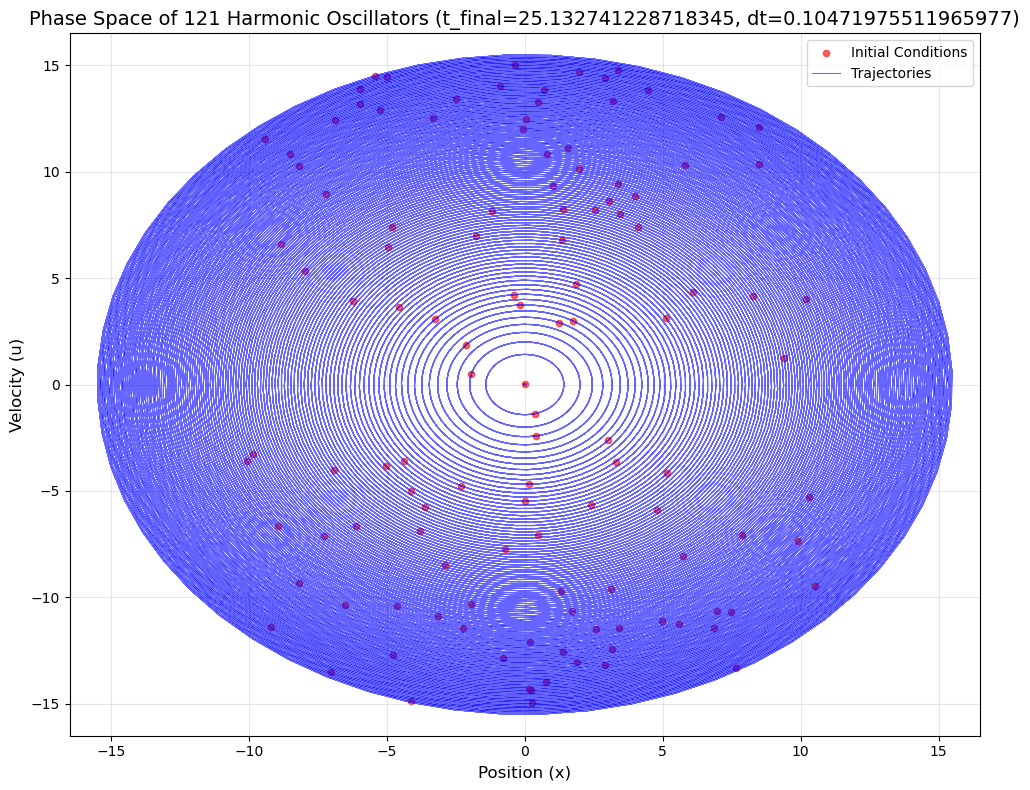

In [14]:
Phase.plot_phase_space(show_sampled=False, show_derivative=False, show_generated=True, plot_limits=None)

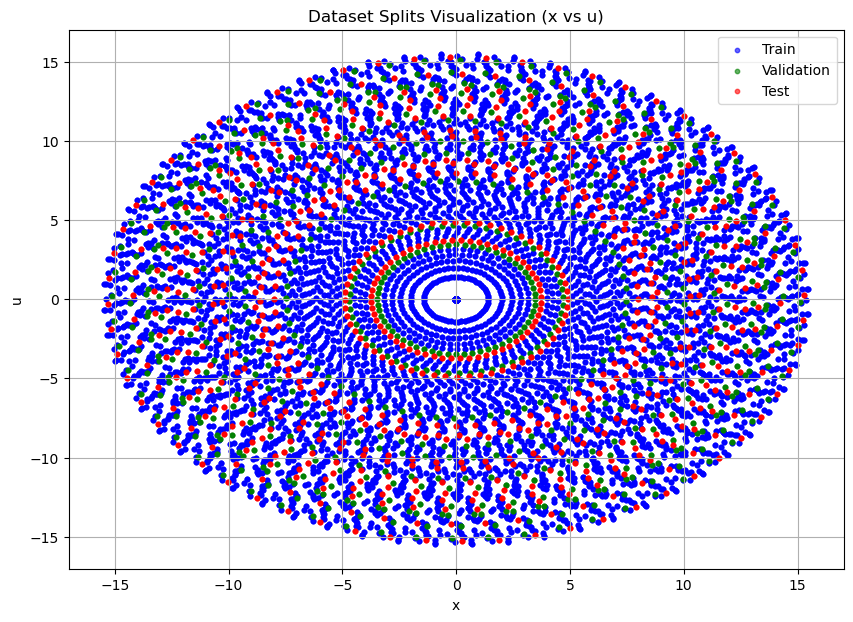

In [15]:
plt.figure(figsize=(10, 7))

plt.scatter(train_df['x'], train_df['u'], color='blue', label='Train', alpha=0.6, s=10)
plt.scatter(val_df['x'], val_df['u'], color='green', label='Validation', alpha=0.6, s=10)
plt.scatter(test_df['x'], test_df['u'], color='red', label='Test', alpha=0.6, s=10)

plt.xlabel('x')
plt.ylabel('u')
plt.title('Dataset Splits Visualization (x vs u)')
plt.legend()
plt.grid(True)
plt.show()

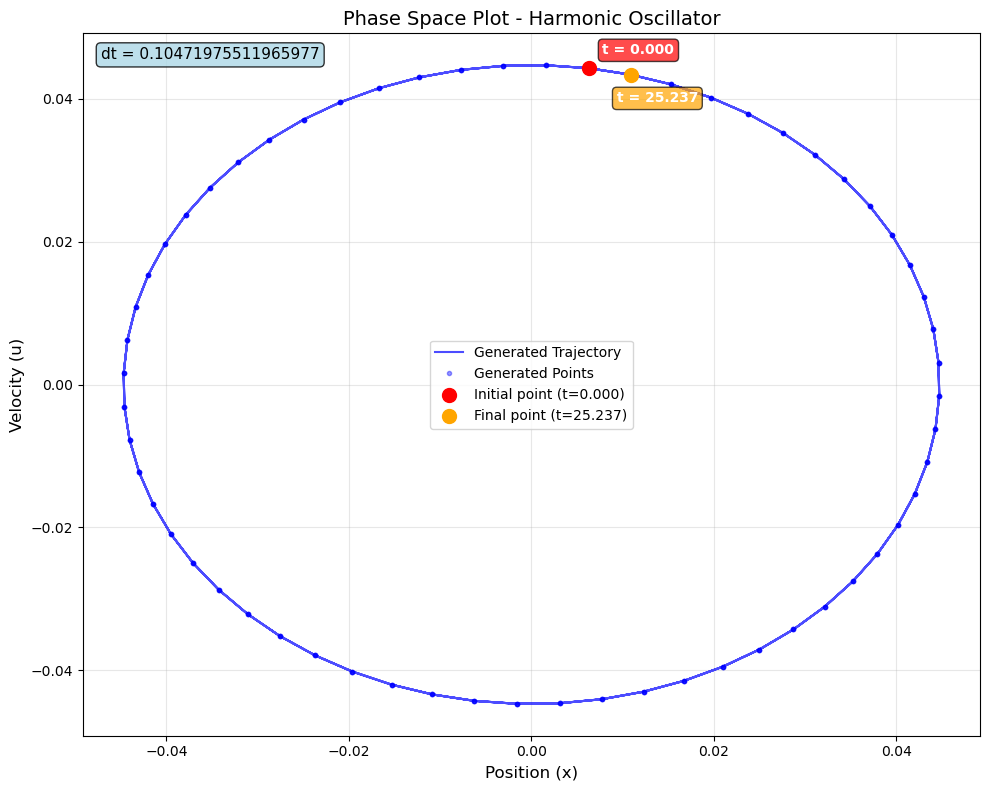

In [16]:
Phase.oscillators[0].plot_points(show_sampled=False, show_derivative=False, show_generated=True)

In [17]:
High_energy_phase_space = PhaseSpace(k=k, mass=mass)


In [18]:
points_per_trajectory_number_of_different_trajectories_ratio_high_energy = 2
samples_per_period_high_energy = 60
periods_per_trajectory_high_energy = 0.75
k=1
mass=1
constant = -(k / mass)
omega = np.sqrt(-constant)
period = 2*np.pi/omega
dt_high_energy = period/samples_per_period_high_energy
Tmax_high_energy = periods_per_trajectory_high_energy*period
points_per_trajectory_high_energy = int(round(Tmax_high_energy / dt_high_energy)) + 2
n_tajectories_high_energy = round(points_per_trajectory_high_energy/points_per_trajectory_number_of_different_trajectories_ratio_high_energy)
total_points_high_energy = n_tajectories_high_energy*points_per_trajectory_high_energy
energy_min_high_energy=120
max_x0_high_energy=100
max_u0_high_energy=100
max_energy_high_energy = 0.5 * (mass * (max_u0_high_energy**2) + k * (max_x0_high_energy**2))

In [19]:
print(f"We have {n_tajectories_high_energy} different trajectories with {points_per_trajectory_high_energy} points per trajectory. That gives us {total_points_high_energy} total points.\nThe max energy sampled is {max_energy_high_energy}, the lowerst is {energy_min_high_energy} and the sampling inteval is {(max_energy_high_energy - energy_min_high_energy) / n_tajectories_high_energy}")

We have 24 different trajectories with 47 points per trajectory. That gives us 1128 total points.
The max energy sampled is 10000.0, the lowerst is 120 and the sampling inteval is 411.6666666666667


In [20]:
High_energy_phase_space.make_oscillators(n_oscillators=n_tajectories_high_energy, max_x0=max_x0_high_energy, max_u0=max_u0_high_energy, method='stratified_energies', energy_min=energy_min_high_energy)

In [21]:
High_energy_phase_space.generate_all_oscillators_points(t_final=Tmax_high_energy, dt=dt_high_energy, analyticaly=True)

Generated a total of 1104 points


In [22]:
id_df_high_energy = High_energy_phase_space.make_trajectories_ids_df()

In [23]:
data_df_high_energy = High_energy_phase_space.make_trajectories_df()

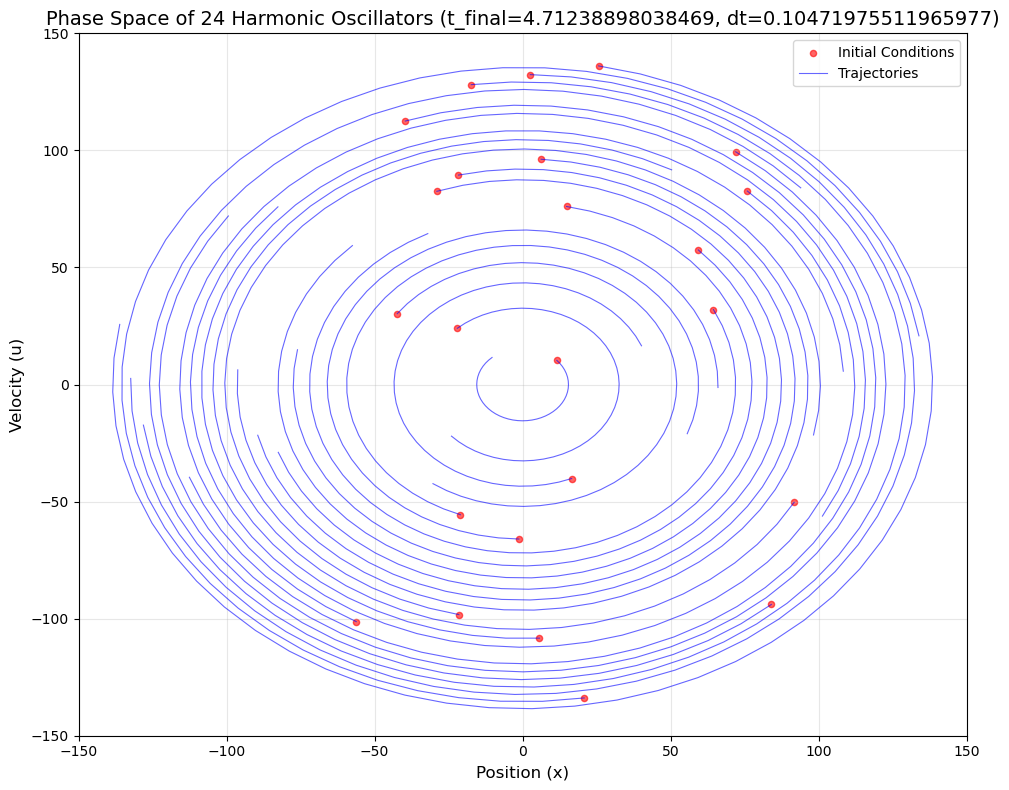

In [24]:
High_energy_phase_space.plot_phase_space(show_sampled=False, show_derivative=False, show_generated=True, plot_limits=None)

In [82]:

def split_trajectories_only_val(ids_df, full_df, test_pct=0.1, random_state=42, bins=10):
    """
    Split oscillator trajectories into train/val/test sets, stratified by energy.

    Args:
        ids_df (pd.DataFrame): Output of make_trajectories_ids_df (one row per oscillator).
        full_df (pd.DataFrame): Output of make_trajectories_df (all trajectory points).
        val_pct (float): Fraction of oscillators to use for validation.
        test_pct (float): Fraction of oscillators to use for test.
        random_state (int): Random seed for reproducibility.
        bins (int): Number of bins to discretize energy for stratification.

    Returns:
        (train_df, val_df, test_df,
         train_id_df, val_id_df, test_id_df)
    """
    # copy to avoid modifying original
    ids_df = ids_df.copy()
    ids_df["energy_bin"] = pd.qcut(ids_df["energy"], q=bins, duplicates="drop")

    # split test first
    val_ids, test_id_df = train_test_split(
        ids_df,
        test_size=test_pct,
        stratify=ids_df["energy_bin"],
        random_state=random_state
    )




    # clean up temporary column
    for df in (val_ids, test_id_df):
        df.drop(columns=["energy_bin"], inplace=True)

    # --- build point-level splits ---
    def gather_points(sub_ids):
        mask = pd.Series(False, index=full_df.index)
        for _, row in sub_ids.iterrows():
            mask.loc[row["start_index"]:row["end_index"]-1] = True
        return full_df[mask]

    val_df   = gather_points(val_ids)
    test_df  = gather_points(test_id_df)

    return val_df, test_df, val_ids, test_id_df


In [26]:
val_df_high_energy, test_df_high_energy, val_id_df_high_energy, test_id_df_high_energy = split_trajectories_only_val(ids_df=id_df_high_energy, full_df=data_df_high_energy, test_pct=0.5, random_state=42, bins=5)

In [27]:
print(f"High energy validation trajectories have a mean energy of {val_id_df_high_energy['energy'].mean()}±{val_id_df_high_energy['energy'].std()}\nHigh energy test trajectories have a mean energy of {test_id_df_high_energy['energy'].mean()}±{test_id_df_high_energy['energy'].std()}")
 

High energy validation trajectories have a mean energy of 5231.527777777778±2965.7580714805767
High energy test trajectories have a mean energy of 4476.805555555556±2934.424165143211


Helper functions

In [7]:
def get_data_from_trajectory_id(ids_df, data_df, trajectory_ids):
    """
    Return the exact portion(s) of `data_df` corresponding to one or more trajectory_ids.
    - Preserves data_df's original indexing (no reset).
    - If trajectory_ids contains all ids in ids_df, returns data_df unchanged.
    - If any requested id is missing, prints missing ids and returns None.
    """
    # normalize to list of ints (preserve order)
    if isinstance(trajectory_ids, (np.integer, int)):
        trajectory_ids = [int(trajectory_ids)]
    else:
        trajectory_ids = [int(x) for x in trajectory_ids]

    # ensure id columns are ints in ids_df
    ids_df = ids_df.copy()
    for col in ("start_index", "end_index", "generated_points", "trajectory_id"):
        if col in ids_df.columns:
            ids_df[col] = ids_df[col].astype("int64")

    existing_ids = list(ids_df["trajectory_id"].values)
    missing = [tid for tid in trajectory_ids if tid not in existing_ids]
    if missing:
        print(f"trajectory_id(s) {missing} not in ids_df. Pick from {existing_ids}")
        return None

    # special-case: request for all trajectories -> return full data_df unchanged
    if set(trajectory_ids) == set(existing_ids):
        return data_df

    parts = []
    for tid in trajectory_ids:
        row = ids_df.loc[ids_df["trajectory_id"] == tid].iloc[0]
        start = int(row["start_index"])
        end = int(row["end_index"])   # exclusive by your convention

        if start >= end:
            # empty trajectory: skip (or you can append an empty frame if you prefer)
            continue

        # label-based selection: .loc is inclusive on the right, so use end-1
        sub = data_df.loc[start : end - 1]
        parts.append(sub)

    if not parts:
        # nothing found (all requested trajectories empty)
        return data_df.iloc[0:0]   # empty DataFrame with same columns

    # if single part, return it directly (preserves original index)
    if len(parts) == 1:
        return parts[0]
    # multiple parts: concatenate preserving indices and order
    return pd.concat(parts)

In [29]:
def get_trajectory_ids_by_energies(ids_df, want_more_energy, energy_percentile):
    if want_more_energy==False:
        return list(ids_df[ids_df['energy'] < ids_df['energy'].quantile(energy_percentile)]['trajectory_id'])
    if want_more_energy==True:
        return list(ids_df[ids_df['energy'] > ids_df['energy'].quantile(energy_percentile)]['trajectory_id'])
    

In [ ]:


# Put all DataFrames into a dictionary
dfs = {
    "data_df": data_df,
    "id_df": id_df,
    "train_df": train_df,
    "val_df": val_df,
    "test_df": test_df,
    "train_id_df": train_id_df,
    "val_id_df": val_id_df,
    "test_id_df": test_id_df,
    "data_df_high_energy": data_df_high_energy,
    "id_df_high_energy": id_df_high_energy,
    "val_df_high_energy": val_df_high_energy,
    "test_df_high_energy": test_df_high_energy,
    "val_id_df_high_energy": val_id_df_high_energy,
    "test_id_df_high_energy": test_id_df_high_energy,
}

# Save everything in one file
with open("all_dataframes.pkl", "wb") as f:
    pickle.dump(dfs, f)

print("✅ All DataFrames saved to all_dataframes.pkl")




✅ All DataFrames saved to all_dataframes.pkl


'\n\nwith open("all_dataframes.pkl", "rb") as f:\n    loaded_dfs = pickle.load(f)\n\n# Access them like before:\ntrain_df_reloaded = loaded_dfs["train_df"]\nprint(train_df_reloaded.head())\n'

In [15]:
High_energy_revised_phase_space = PhaseSpace(k=k, mass=mass)


In [26]:
points_per_trajectory_number_of_different_trajectories_ratio_high_energy_revised = 2
samples_per_period_high_energy_revised = 60
periods_per_trajectory_high_energy_revised = 1
k=1
mass=1
constant = -(k / mass)
omega = np.sqrt(-constant)
period = 2*np.pi/omega
dt_high_energy_revised = period/samples_per_period_high_energy_revised
Tmax_high_energy_revised = periods_per_trajectory_high_energy_revised*period
points_per_trajectory_high_energy_revised = int(round(Tmax_high_energy_revised / dt_high_energy_revised)) + 2
n_tajectories_high_energy_revised = round(points_per_trajectory_high_energy_revised/points_per_trajectory_number_of_different_trajectories_ratio_high_energy_revised)
total_points_high_energy_revised = n_tajectories_high_energy_revised*points_per_trajectory_high_energy_revised
energy_min_high_energy_revised=121
max_x0_high_energy_revised=16
max_u0_high_energy_revised=16
max_energy_high_energy_revised = 0.5 * (mass * (max_u0_high_energy_revised**2) + k * (max_x0_high_energy_revised**2))

In [12]:
print(f"We have {n_tajectories_high_energy_revised} different trajectories with {points_per_trajectory_high_energy_revised} points per trajectory. That gives us {total_points_high_energy_revised} total points.\nThe max energy sampled is {max_energy_high_energy_revised}, the lowerst is {energy_min_high_energy_revised} and the sampling inteval is {(max_energy_high_energy_revised - energy_min_high_energy_revised) / n_tajectories_high_energy_revised}")

NameError: name 'n_tajectories_high_energy_revised' is not defined

In [28]:
High_energy_revised_phase_space.make_oscillators(n_oscillators=n_tajectories_high_energy_revised, max_x0=max_x0_high_energy_revised, max_u0=max_u0_high_energy_revised, method='stratified_energies', energy_min=energy_min_high_energy_revised)

In [29]:
High_energy_revised_phase_space.generate_all_oscillators_points(t_final=Tmax_high_energy_revised, dt=dt_high_energy_revised, analyticaly=True)

Generated a total of 1891 points


In [30]:
id_df_high_energy_revised = High_energy_revised_phase_space.make_trajectories_ids_df()

In [31]:
data_df_high_energy_revised = High_energy_revised_phase_space.make_trajectories_df()

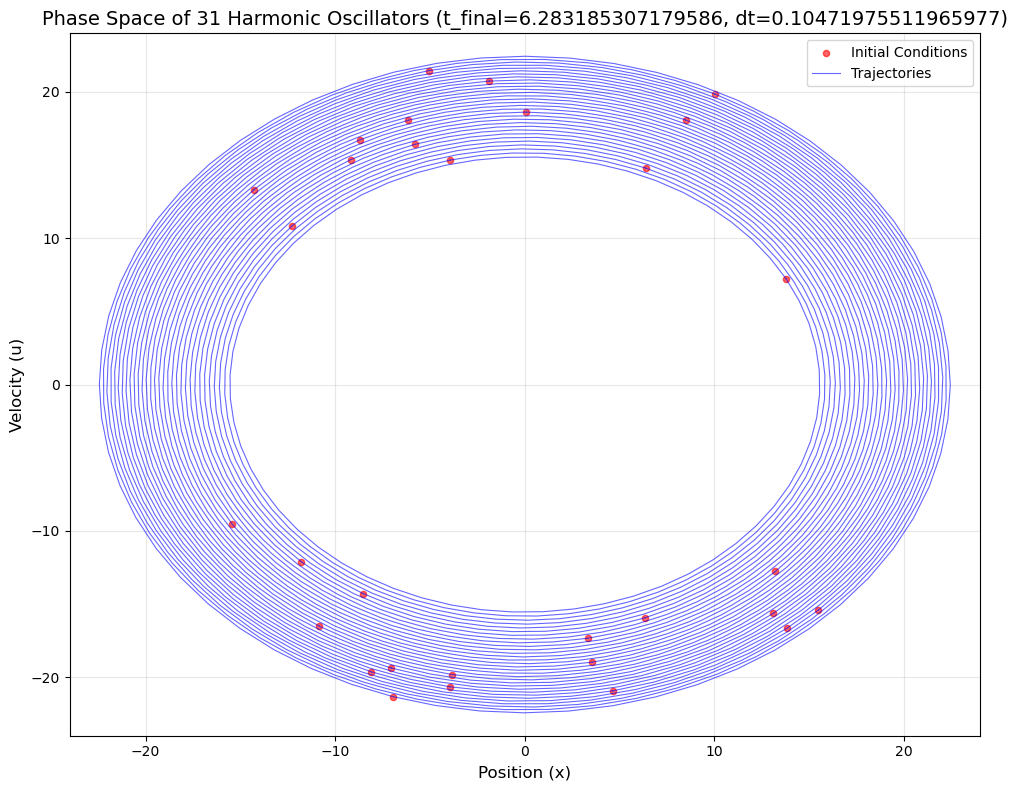

In [32]:
High_energy_revised_phase_space.plot_phase_space(show_sampled=False, show_derivative=False, show_generated=True, plot_limits=None)

In [35]:
val_df_high_energy_revised, test_df_high_energy_revised, val_id_df_high_energy_revised, test_id_df_high_energy_revised = split_trajectories_only_val(ids_df=id_df_high_energy_revised, full_df=data_df_high_energy_revised, test_pct=0.5, random_state=42, bins=5)

In [ ]:
print(f"High energy validation trajectories have a mean energy of {val_id_df_high_energy_revised['energy'].mean()}±{val_id_df_high_energy_revised['energy'].std()}\nHigh energy test trajectories have a mean energy of {test_id_df_high_energy_revised['energy'].mean()}±{test_id_df_high_energy_revised['energy'].std()}")
 

High energy validation trajectories have a mean energy of 186.90322580645162±42.88597588149142
High energy test trajectories have a mean energy of 185.77822580645162±37.659494327556814


In [36]:
dfs_high_energy_revised = {

    "val_df_high_energy_revised": val_df_high_energy_revised,
    "test_df_high_energy_revised": test_df_high_energy_revised,
    "val_id_df_high_energy_revised": val_id_df_high_energy_revised,
    "test_id_df_high_energy_revised": test_id_df_high_energy_revised,

}

# Save everything in one file
with open("df_high_energy_revised.pkl", "wb") as f:
    pickle.dump(dfs_high_energy_revised, f)

print("✅ All DataFrames saved to df_high_energy_revised.pkl")

✅ All DataFrames saved to df_high_energy_revised.pkl


In [ ]:
points_per_trajectory_number_of_different_trajectories_ratio_low_samples = 0.43
samples_per_period_low_samples = 30
periods_per_trajectory_low_samples = 1
k=1
mass=1
constant = -(k / mass)
omega = np.sqrt(-constant)
period = 2*np.pi/omega
dt_low_samples = period/samples_per_period_low_samples
Tmax_low_samples = periods_per_trajectory_low_samples*period
points_per_trajectory_low_samples = int(round(Tmax_low_samples / dt_low_samples)) + 2
n_tajectories_low_samples = round(points_per_trajectory_low_samples/points_per_trajectory_number_of_different_trajectories_ratio_low_samples)
total_points_low_samples = n_tajectories_low_samples*points_per_trajectory_low_samples
energy_min_low_samples=0.2
max_x0_low_samples=1
max_u0_low_samples=1
max_energy_low_samples = 0.5 * (mass * (max_u0_low_samples**2) + k * (max_x0_low_samples**2))
val_pct_low_samples = 0.33
test_pct_low_samples = 0.33

training_trajectories_low_samples = round((1-val_pct_low_samples-test_pct_low_samples)*n_tajectories_low_samples)
training_samples_low_samples = training_trajectories_low_samples*points_per_trajectory_low_samples
validation_trajectories_low_samples = round(val_pct_low_samples*n_tajectories_low_samples)
validation_samples_low_samples = validation_trajectories_low_samples*points_per_trajectory_low_samples
test_trajectories_low_samples=round(test_pct_low_samples*n_tajectories_low_samples)
test_samples_low_samples=test_trajectories_low_samples*points_per_trajectory_low_samples

In [68]:
dt_low_samples

np.float64(0.20943951023931953)

In [69]:
print(f"We have {n_tajectories_low_samples} different trajectories with {points_per_trajectory_low_samples} points per trajectory. That gives us {total_points_low_samples} total points.\n\nThat splits in:\n{training_trajectories_low_samples} training trajectories with {training_samples_low_samples} samples.\n{validation_trajectories_low_samples} validation trajectories with {validation_samples_low_samples} samples\n{test_trajectories_low_samples} test trajectories with {test_samples_low_samples} samples\nThe max energy sampled is {max_energy_low_samples}, the lowerst is {energy_min_low_samples} and the sampling inteval is {(max_energy_low_samples - energy_min_low_samples) / n_tajectories_low_samples}")

We have 74 different trajectories with 32 points per trajectory. That gives us 2368 total points.

That splits in:
25 training trajectories with 800 samples.
24 validation trajectories with 768 samples
24 test trajectories with 768 samples
The max energy sampled is 1.0, the lowerst is 0.2 and the sampling inteval is 0.010810810810810811


In [70]:
Phase_space_low_samples = PhaseSpace(k=k, mass=mass)

In [71]:
Phase_space_low_samples.make_oscillators(n_oscillators=n_tajectories_low_samples, max_x0=max_x0_low_samples, max_u0=max_u0_low_samples, method='stratified_energies', energy_min=energy_min_low_samples)

In [72]:
Phase_space_low_samples.generate_all_oscillators_points(t_final=Tmax_low_samples, dt=dt_low_samples, analyticaly=True)

Generated a total of 2368 points


In [73]:
id_df_low_samples = Phase_space_low_samples.make_trajectories_ids_df()

In [74]:
data_df_low_samples = Phase_space_low_samples.make_trajectories_df()

In [75]:
train_df_low_samples, val_df_low_samples, test_df_low_samples, train_id_df_low_samples, val_id_df_low_samples, test_id_df_low_samples = split_trajectories(ids_df=id_df_low_samples, full_df=data_df_low_samples, val_pct=val_pct_low_samples, test_pct=test_pct_low_samples, random_state=42, bins=11)

In [76]:
print(f"Training trajectories have a mean energy of {train_id_df_low_samples['energy'].mean()}±{train_id_df_low_samples['energy'].std()}\nValidation trajectories have a mean energy of {val_id_df_low_samples['energy'].mean()}±{val_id_df_low_samples['energy'].std()}\nTest trajectories have a mean energy of {test_id_df_low_samples['energy'].mean()}±{test_id_df_low_samples['energy'].std()}\n")
 

Training trajectories have a mean energy of 0.5878378378378378±0.2356336813996533
Validation trajectories have a mean energy of 0.5917837837837837±0.24312870176035103
Test trajectories have a mean energy of 0.603891891891892±0.22792358362131285



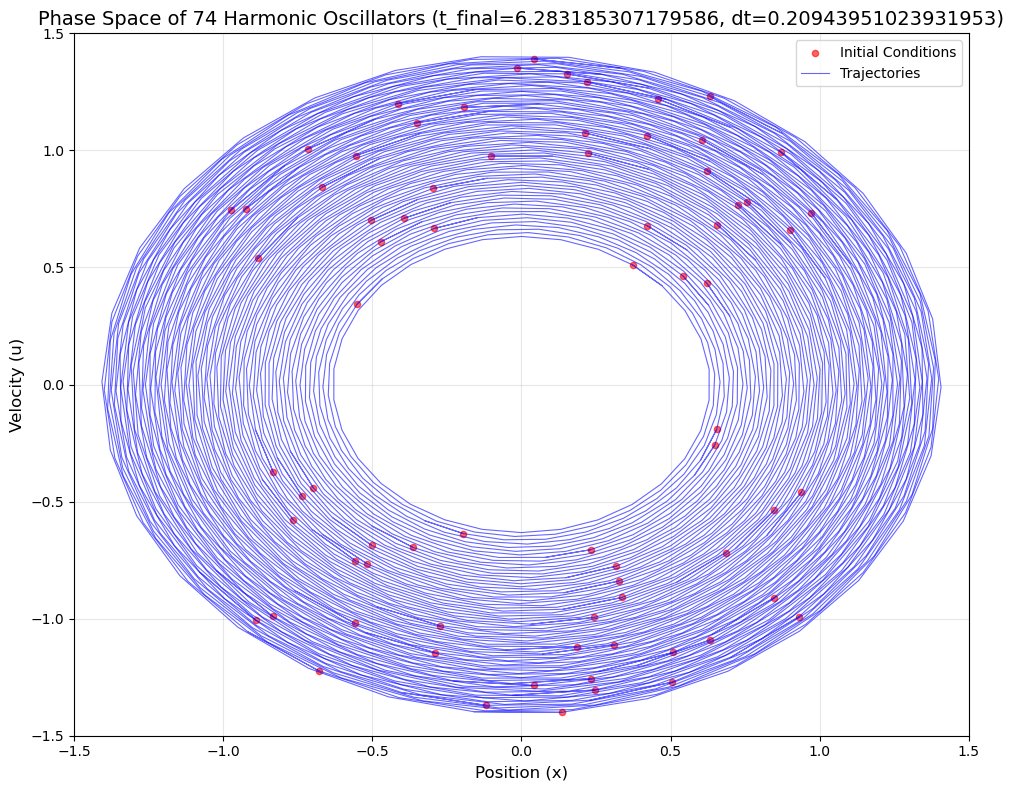

In [77]:
Phase_space_low_samples.plot_phase_space(show_sampled=False, show_derivative=False, show_generated=True, plot_limits=None)

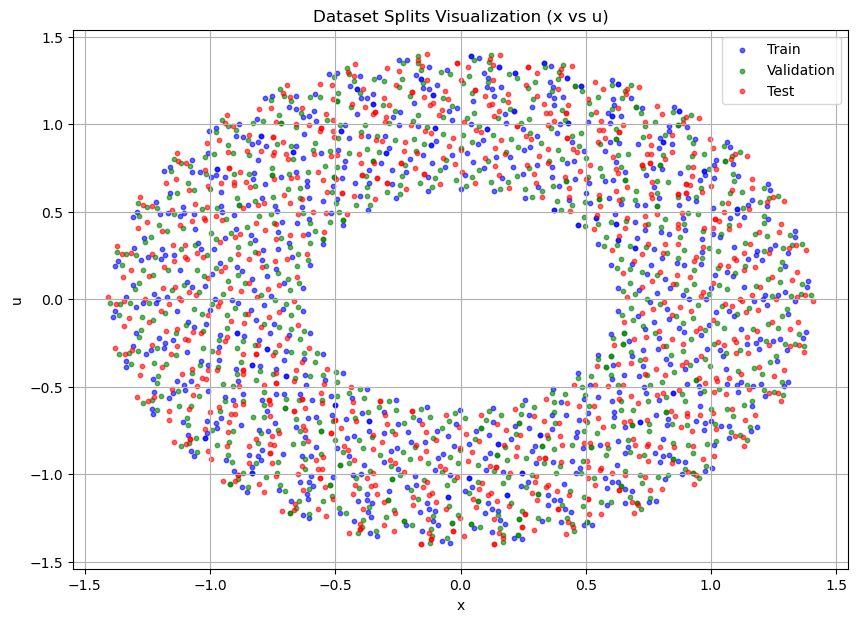

In [78]:
plt.figure(figsize=(10, 7))

plt.scatter(train_df_low_samples['x'], train_df_low_samples['u'], color='blue', label='Train', alpha=0.6, s=10)
plt.scatter(val_df_low_samples['x'], val_df_low_samples['u'], color='green', label='Validation', alpha=0.6, s=10)
plt.scatter(test_df_low_samples['x'], test_df_low_samples['u'], color='red', label='Test', alpha=0.6, s=10)

plt.xlabel('x')
plt.ylabel('u')
plt.title('Dataset Splits Visualization (x vs u)')
plt.legend()
plt.grid(True)
plt.show()

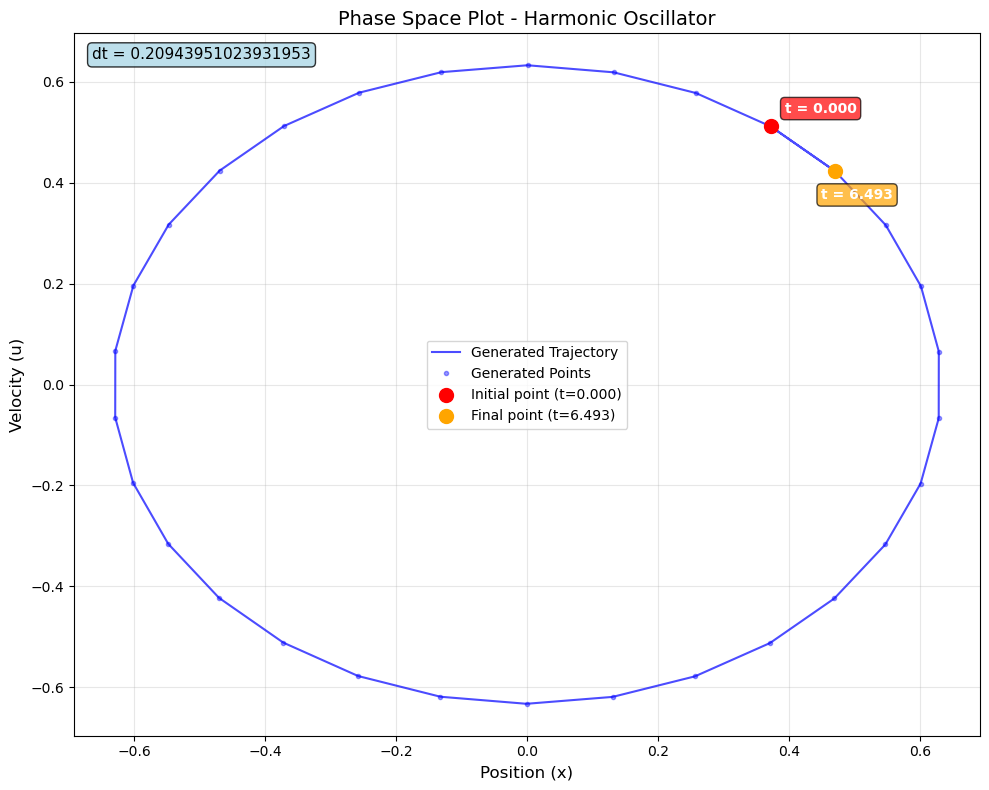

In [79]:
Phase_space_low_samples.oscillators[0].plot_points(show_sampled=False, show_derivative=False, show_generated=True)

In [124]:


# Put all DataFrames into a dictionary
dfs_low_samples = {
    "data_df_low_samples": data_df_low_samples,
    "id_df_low_samples": id_df_low_samples,
    "train_df_low_samples": train_df_low_samples,
    "val_df_low_samples": val_df_low_samples,
    "test_df_low_samples": test_df_low_samples,
    "train_id_df_low_samples": train_id_df_low_samples,
    "val_id_df_low_samples": val_id_df_low_samples,
    "test_id_df_low_samples": test_id_df_low_samples,
}

# Save everything in one file
with open("all_dataframes_low_samples.pkl", "wb") as f:
    pickle.dump(dfs_low_samples, f)

print("✅ All DataFrames saved to all_dataframes_low_samples.pkl")




✅ All DataFrames saved to all_dataframes_low_samples.pkl


In [69]:
points_per_trajectory_number_of_different_trajectories_ratio_low_samples_multiple_periods = 4
samples_per_period_low_samples_multiple_periods = 30
periods_per_trajectory_low_samples_multiple_periods = 3.183098861837907
k=1
mass=1
constant = -(k / mass)
omega = np.sqrt(-constant)
period = 2*np.pi/omega
dt_low_samples_multiple_periods = period/samples_per_period_low_samples_multiple_periods
Tmax_low_samples_multiple_periods = periods_per_trajectory_low_samples_multiple_periods*period
points_per_trajectory_low_samples_multiple_periods = int(round(Tmax_low_samples_multiple_periods / dt_low_samples_multiple_periods)) + 2
n_tajectories_low_samples_multiple_periods = round(points_per_trajectory_low_samples_multiple_periods/points_per_trajectory_number_of_different_trajectories_ratio_low_samples_multiple_periods)
total_points_low_samples_multiple_periods = n_tajectories_low_samples_multiple_periods*points_per_trajectory_low_samples_multiple_periods
energy_min_low_samples_multiple_periods=0.2
max_x0_low_samples_multiple_periods=1
max_u0_low_samples_multiple_periods=1
max_energy_low_samples_multiple_periods = 0.5 * (mass * (max_u0_low_samples_multiple_periods**2) + k * (max_x0_low_samples_multiple_periods**2))
val_pct_low_samples_multiple_periods = 0.0
test_pct_low_samples_multiple_periods = 0.0

training_trajectories_low_samples_multiple_periods = round((1-val_pct_low_samples_multiple_periods-test_pct_low_samples_multiple_periods)*n_tajectories_low_samples_multiple_periods)
training_samples_low_samples_multiple_periods = training_trajectories_low_samples_multiple_periods*points_per_trajectory_low_samples_multiple_periods
validation_trajectories_low_samples_multiple_periods = round(val_pct_low_samples_multiple_periods*n_tajectories_low_samples_multiple_periods)
validation_samples_low_samples_multiple_periods = validation_trajectories_low_samples_multiple_periods*points_per_trajectory_low_samples_multiple_periods
test_trajectories_low_samples_multiple_periods=round(test_pct_low_samples_multiple_periods*n_tajectories_low_samples_multiple_periods)
test_samples_low_samples_multiple_periods=test_trajectories_low_samples_multiple_periods*points_per_trajectory_low_samples_multiple_periods

In [70]:
dt_low_samples_multiple_periods

np.float64(0.20943951023931953)

In [71]:
print(f"We have {n_tajectories_low_samples_multiple_periods} different trajectories with {points_per_trajectory_low_samples_multiple_periods} points per trajectory. That gives us {total_points_low_samples_multiple_periods} total points.\n\nThat splits in:\n{training_trajectories_low_samples_multiple_periods} training trajectories with {training_samples_low_samples_multiple_periods} samples.\n{validation_trajectories_low_samples_multiple_periods} validation trajectories with {validation_samples_low_samples_multiple_periods} samples\n{test_trajectories_low_samples_multiple_periods} test trajectories with {test_samples_low_samples_multiple_periods} samples\nThe max energy sampled is {max_energy_low_samples_multiple_periods}, the lowerst is {energy_min_low_samples_multiple_periods} and the sampling inteval is {(max_energy_low_samples_multiple_periods - energy_min_low_samples_multiple_periods) / n_tajectories_low_samples_multiple_periods}")

We have 24 different trajectories with 97 points per trajectory. That gives us 2328 total points.

That splits in:
24 training trajectories with 2328 samples.
0 validation trajectories with 0 samples
0 test trajectories with 0 samples
The max energy sampled is 1.0, the lowerst is 0.2 and the sampling inteval is 0.03333333333333333


In [72]:
Phase_space_low_samples_multiple_periods = PhaseSpace(k=k, mass=mass)

In [75]:
Phase_space_low_samples_multiple_periods.make_oscillators(n_oscillators=n_tajectories_low_samples_multiple_periods, max_x0=max_x0_low_samples_multiple_periods, max_u0=max_u0_low_samples_multiple_periods, method='stratified_energies', energy_min=energy_min_low_samples_multiple_periods)

In [76]:
Phase_space_low_samples_multiple_periods.generate_all_oscillators_points(t_final=Tmax_low_samples_multiple_periods, dt=dt_low_samples_multiple_periods, analyticaly=True)

Generated a total of 2328 points


In [77]:
id_df_low_samples_multiple_periods = Phase_space_low_samples_multiple_periods.make_trajectories_ids_df()

In [78]:
data_df_low_samples_multiple_periods = Phase_space_low_samples_multiple_periods.make_trajectories_df()

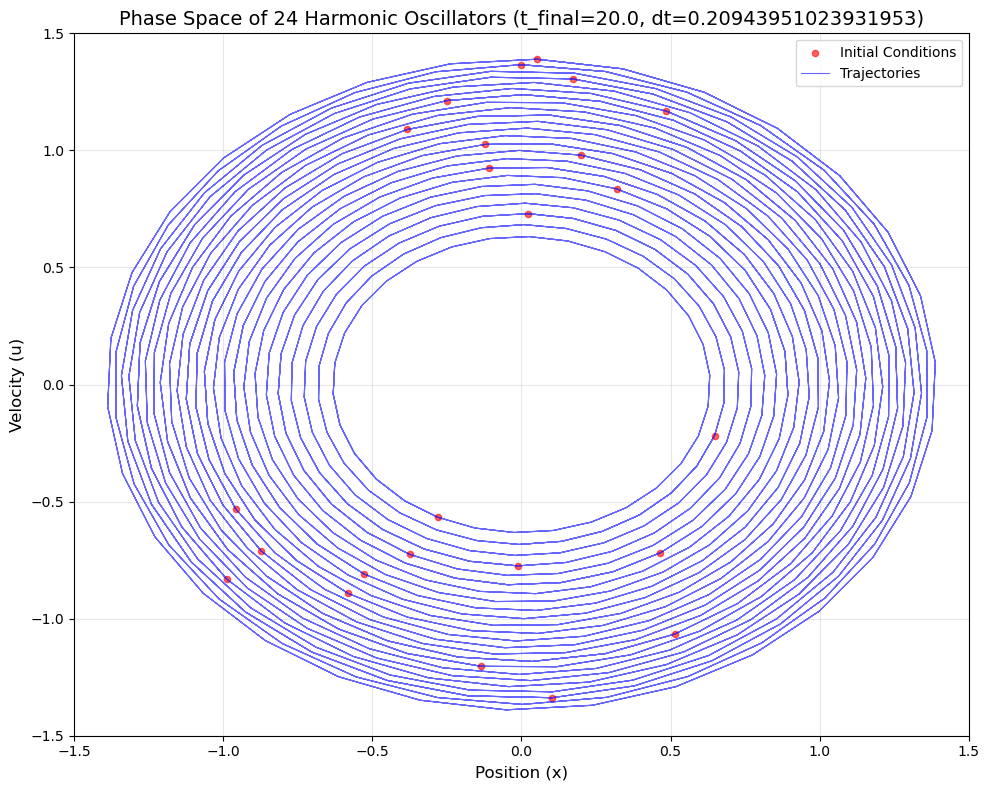

In [79]:
Phase_space_low_samples_multiple_periods.plot_phase_space(show_sampled=False, show_derivative=False, show_generated=True, plot_limits=None)

In [80]:


# Put all DataFrames into a dictionary
dfs_low_samples_multiple_periods = {
    "data_df_low_samples_multiple_periods": data_df_low_samples_multiple_periods,
    "id_df_low_samples_multiple_periods": id_df_low_samples_multiple_periods,
}

# Save everything in one file
with open("all_dataframes_low_samples_multiple_periods.pkl", "wb") as f:
    pickle.dump(dfs_low_samples_multiple_periods, f)

print("✅ All DataFrames saved to all_dataframes_low_samples_multiple_periods.pkl")




✅ All DataFrames saved to all_dataframes_low_samples_multiple_periods.pkl


MEXRI EDW

In [ ]:
High_energy_low_samples_phase_space = PhaseSpace(k=k, mass=mass)


In [126]:
points_per_trajectory_number_of_different_trajectories_ratio_high_energy_low_samples = 0.65
samples_per_period_high_energy_low_samples = 30
periods_per_trajectory_high_energy_low_samples = 1
k=1
mass=1
constant = -(k / mass)
omega = np.sqrt(-constant)
period = 2*np.pi/omega
dt_high_energy_low_samples = period/samples_per_period_high_energy_low_samples
Tmax_high_energy_low_samples = periods_per_trajectory_high_energy_low_samples*period
points_per_trajectory_high_energy_low_samples = int(round(Tmax_high_energy_low_samples / dt_high_energy_low_samples)) + 2
n_tajectories_high_energy_low_samples = round(points_per_trajectory_high_energy_low_samples/points_per_trajectory_number_of_different_trajectories_ratio_high_energy_low_samples)
total_points_high_energy_low_samples = n_tajectories_high_energy_low_samples*points_per_trajectory_high_energy_low_samples
energy_min_high_energy_low_samples=1.1
max_x0_high_energy_low_samples=1.4
max_u0_high_energy_low_samples=1.4
max_energy_high_energy_low_samples = 0.5 * (mass * (max_u0_high_energy_low_samples**2) + k * (max_x0_high_energy_low_samples**2))

In [127]:
print(f"We have {n_tajectories_high_energy_low_samples} different trajectories with {points_per_trajectory_high_energy_low_samples} points per trajectory. That gives us {total_points_high_energy_low_samples} total points.\nThe max energy sampled is {max_energy_high_energy_low_samples}, the lowerst is {energy_min_high_energy_low_samples} and the sampling inteval is {(max_energy_high_energy_low_samples - energy_min_high_energy_low_samples) / n_tajectories_high_energy_low_samples}")

We have 49 different trajectories with 32 points per trajectory. That gives us 1568 total points.
The max energy sampled is 1.9599999999999997, the lowerst is 1.1 and the sampling inteval is 0.017551020408163257


In [128]:
High_energy_low_samples_phase_space.make_oscillators(n_oscillators=n_tajectories_high_energy_low_samples, max_x0=max_x0_high_energy_low_samples, max_u0=max_u0_high_energy_low_samples, method='stratified_energies', energy_min=energy_min_high_energy_low_samples)

In [129]:
High_energy_low_samples_phase_space.generate_all_oscillators_points(t_final=Tmax_high_energy_low_samples, dt=dt_high_energy_low_samples, analyticaly=True)

Generated a total of 1568 points


In [130]:
id_df_high_energy_low_samples = High_energy_low_samples_phase_space.make_trajectories_ids_df()

In [131]:
data_df_high_energy_low_samples = High_energy_low_samples_phase_space.make_trajectories_df()

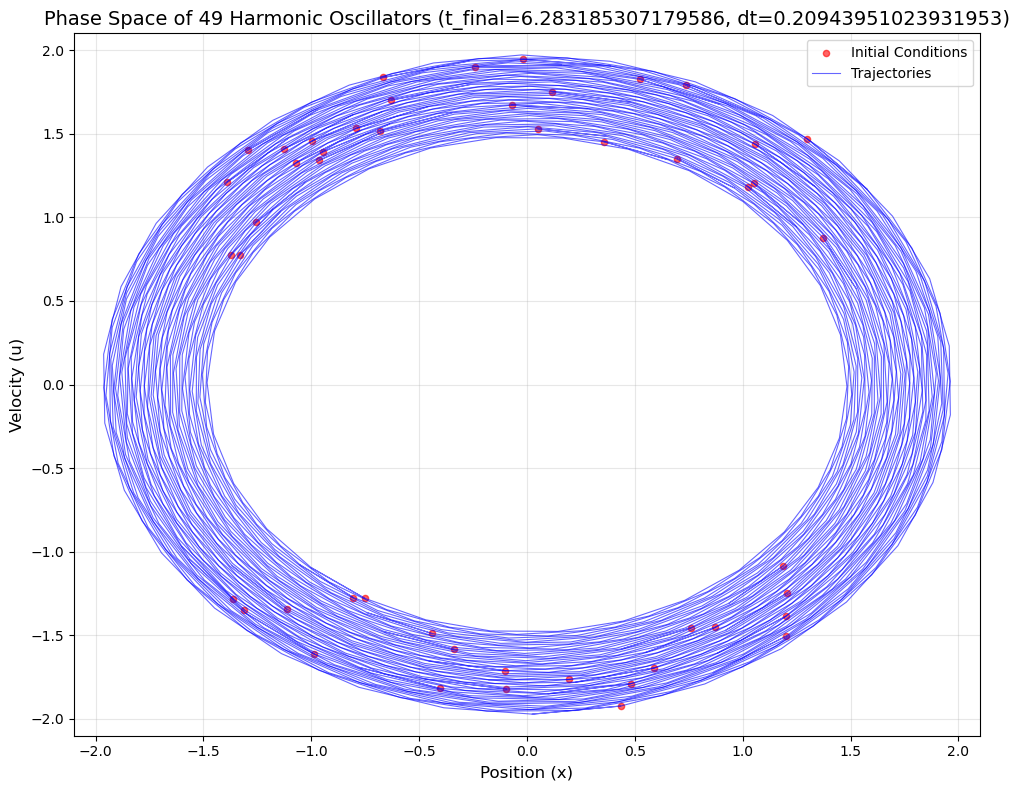

In [132]:
High_energy_low_samples_phase_space.plot_phase_space(show_sampled=False, show_derivative=False, show_generated=True, plot_limits=None)

In [133]:
val_df_high_energy_low_samples, test_df_high_energy_low_samples, val_id_df_high_energy_low_samples, test_id_df_high_energy_low_samples = split_trajectories_only_val(ids_df=id_df_high_energy_low_samples, full_df=data_df_high_energy_low_samples, test_pct=0.5, random_state=42, bins=5)

In [134]:
print(f"High energy validation trajectories have a mean energy of {val_id_df_high_energy_low_samples['energy'].mean()}±{val_id_df_high_energy_low_samples['energy'].std()}\nHigh energy test trajectories have a mean energy of {test_id_df_high_energy_low_samples['energy'].mean()}±{test_id_df_high_energy_low_samples['energy'].std()}")
 

High energy validation trajectories have a mean energy of 1.5285374149659863±0.2602679613754777
High energy test trajectories have a mean energy of 1.514204081632653±0.24649656813187332


In [137]:
dfs_high_energy_low_samples = {

    "val_df_high_energy_low_samples": val_df_high_energy_low_samples,
    "test_df_high_energy_low_samples": test_df_high_energy_low_samples,
    "val_id_df_high_energy_low_samples": val_id_df_high_energy_low_samples,
    "test_id_df_high_energy_low_samples": test_id_df_high_energy_low_samples,

}

# Save everything in one file
with open("df_high_energy_low_samples.pkl", "wb") as f:
    pickle.dump(dfs_high_energy_low_samples, f)

print("✅ All DataFrames saved to df_high_energy_low_samples.pkl")

✅ All DataFrames saved to df_high_energy_low_samples.pkl


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import ellipk, ellipj, ellipkinc
import random

class ideal_pendulum_GPT:
    """
    Robust nonlinear pendulum (full-range) using accurate numerical integration.
    Public API matches original 'ideal_pendulum'.

    Additional: computes the integration constant `phi0` (nonlinear phase)
    for every mode (oscillating / separatrix / rotating).
    """

    def __init__(self, g, length, x0, u0):
        # Physical parameters
        self.g = float(g)
        self.length = float(length)
        self.constant = self.g / self.length      # = omega0^2
        self.omega_n = np.sqrt(self.constant)

        # Initial conditions (store raw)
        self.initial_conditions = np.array([float(x0), float(u0)])
        self.x0 = float(x0)
        self.u0 = float(u0)
        # normalized angle for metadata
        self.x0_normalized = np.arctan2(np.sin(self.x0), np.cos(self.x0))

        # Energy (same expression you used)
        self.energy = 0.5 * (self.u0**2) + self.constant * (1 - np.cos(self.x0))
        self.E_critical = 2 * self.constant

        # Classify regime
        rel = abs(self.energy - self.E_critical) / max(self.E_critical, 1e-12)
        if rel < 1e-10:
            self.motion_type = "separatrix"
        elif self.energy < self.E_critical:
            self.motion_type = "oscillating"
        else:
            self.motion_type = "rotating"

        # Fields saved for compatibility
        self.k = None
        self.k_squared = None
        self.K = None
        self.period = None

        # Compute regime-specific parameters (k, K, period)
        if self.motion_type == "oscillating":
            # Determine theta_max from energy: energy = omega0^2 * (1 - cos(theta_max))
            cos_theta_max = 1.0 - (self.energy / self.constant)
            cos_theta_max = np.clip(cos_theta_max, -1.0, 1.0)
            theta_max = np.arccos(cos_theta_max)

            # modulus k
            self.k = np.sin(theta_max / 2.0)
            self.k_squared = float(self.k**2)
            self.K = float(ellipk(self.k_squared))
            # exact nonlinear period: T = 4 * K / omega0
            self.period = 4.0 * self.K / self.omega_n

        elif self.motion_type == "separatrix":
            self.k = 1.0
            self.k_squared = 1.0
            self.K = np.inf
            self.period = np.inf

        else:  # rotating
            # For rotating motion we keep a conventional parameter used in many references:
            # k_rot^2 = 2 * omega0^2 / energy   (this is < 1 when E > 2*omega0^2 if using that def)
            # We'll store it for reference.
            self.k_squared = float(2.0 * self.constant / max(self.energy, 1e-30))
            self.k = np.sqrt(max(self.k_squared, 0.0))
            self.K = float(ellipk(self.k_squared)) if (0.0 <= self.k_squared < 1.0) else None
            self.period = np.inf  # no finite physical period for full rotation

        # -------------------------
        # Compute the nonlinear integration constant phi0
        # -------------------------
        # phi0 is defined so that the analytic elliptic-form solutions evaluate
        # to the initial conditions at t=0. For oscillating we use:
        #   sin(x0/2) = k * sn(phi0, m),  m = k^2
        # so phi0 = F(arcsin( sin(x0/2) / k ), m)
        # For rotating we follow a similar inversion using cn or sn depending on parameterization.
        self.phi0 = None
        self._compute_phi0()

        # Storage (same fields as before)
        self.generated_points = None
        self.sampled_points = None
        self.dt_used_for_generation = None
        self.t_final_used_for_generation = None
        self.all_gradients = None

        # cache for dense solution
        self._dense_sol = None
        self._dense_t_span = (None, None)


    # -------------------------
    # internal: compute phi0 for all regimes
    # -------------------------
    def _compute_phi0(self):
        # helper safety
        x0 = self.x0
        u0 = self.u0

        if self.motion_type == "oscillating":
            # modulus m
            m = self.k_squared
            # sn argument value (must be within [-1,1])
            sn_val = np.sin(x0 / 2.0) / (self.k if self.k != 0 else 1.0)
            sn_val = np.clip(sn_val, -1.0, 1.0)

            # principal value (amplitude) via inverse-sn: phi = F(arcsin(sn_val), m)
            # ellipkinc(phi, m) returns F(phi|m) when phi is amplitude; we need F(arcsin(sn_val), m)
            # So compute phi0_candidate as F(arcsin(sn_val), m)
            try:
                phi_cand = float(ellipkinc(np.arcsin(sn_val), m))
            except Exception:
                # fallback numerical safe: use arcsin(sn_val) as amplitude (small k)
                phi_cand = float(np.arcsin(sn_val))

            # We must choose the correct branch so the velocity sign matches u0.
            # Evaluate elliptic functions at phi candidates and possible symmetric branches
            # Candidate list: phi_cand, -phi_cand, 2K - phi_cand, -2K - phi_cand
            cand_list = [phi_cand, -phi_cand]
            if self.K is not None and np.isfinite(self.K):
                cand_list += [2.0 * self.K - phi_cand, -2.0 * self.K - phi_cand]

            best_phi = cand_list[0]
            best_err = np.inf
            for phi_try in cand_list:
                sn, cn, dn, _ = ellipj(phi_try, m)
                # compute velocity formula for oscillation branch:
                denom = np.sqrt(max(1.0 - (self.k_squared * (sn**2)), 0.0))
                if denom > 1e-16:
                    u_calc = 2.0 * self.k * self.omega_n * cn * dn / denom
                else:
                    u_calc = 0.0
                # angle match check (use sin(x/2) comparison)
                x_calc = 2.0 * np.arcsin(np.clip(self.k * sn, -1.0, 1.0))
                # compare sin(x) to handle ± branches
                if abs(np.sin(x_calc) - np.sin(self.x0)) < 1e-6:
                    err = abs(u_calc - u0)
                    if err < best_err:
                        best_err = err
                        best_phi = phi_try

            self.phi0 = float(best_phi)

        elif self.motion_type == "rotating":
            # For rotating motion there are multiple parameterizations in literature.
            # We follow the approach similar to your original code: invert cn from velocity if possible,
            # else fall back to sn-inversion style. Use k_rot^2 stored in self.k_squared.
            m = self.k_squared
            # If u_avg and other rotating parameters are available in analytic forms they would be used.
            # Here compute phi0 from cn relation if feasible:
            # cn(phi0) = (u0/u_avg - 1)/k   (from your original derivation)
            # but u_avg depends on energy; compute it similarly:
            try:
                u_avg = np.sign(u0) * np.sqrt(max(2.0 * (self.energy - self.constant), 0.0))
                self.u_avg = u_avg
            except Exception:
                self.u_avg = 0.0
                u_avg = 0.0

            # If u_avg small, fallback to simple phase 0
            if abs(u_avg) > 1e-12 and (self.k is not None and abs(self.k) > 1e-12):
                cn_val = (u0 / u_avg - 1.0) / self.k
                cn_val = np.clip(cn_val, -1.0, 1.0)
                # amplitude from arccos
                am_val = np.arccos(cn_val)
                # map to elliptic integral domain
                try:
                    phi_candidate = float(ellipkinc(am_val, m))
                except Exception:
                    phi_candidate = float(am_val)

                # choose branch considering sign of velocity (cn*dn sign)
                cand_list = [phi_candidate]
                if self.K is not None and np.isfinite(self.K):
                    cand_list += [2.0 * self.K - phi_candidate, -phi_candidate, -2.0 * self.K - phi_candidate]

                best_phi = cand_list[0]
                best_err = np.inf
                for phi_try in cand_list:
                    sn, cn, dn, _ = ellipj(phi_try, m)
                    # approximate u_calc formula used in original rotating attempt (scaled)
                    # we can't use same closed form as oscillatory; this is a branch choice step only
                    u_calc = u_avg * (1.0 + self.k * cn) if (self.k is not None) else u_avg
                    # compute x candidate via am = arctan2(sn, cn)
                    am = np.arctan2(sn, cn)
                    # x_calc approximate (modulo 2pi) - not used strictly for exact match, just for sanity
                    x_calc = 2.0 * am
                    err = abs(u_calc - u0) + abs(np.sin(x_calc) - np.sin(self.x0))
                    if err < best_err:
                        best_err = err
                        best_phi = phi_try

                self.phi0 = float(best_phi)
            else:
                # fallback: define phi0 via sn-inverse with complementary approach (safe numeric)
                # use s = k * sin(x0/2) clipped into [-1,1], then phi0 = F(arcsin(s), 1/k^2)
                if (self.k is None) or (self.k == 0):
                    self.phi0 = 0.0
                else:
                    s = self.k * np.sin(self.x0 / 2.0)
                    s = np.clip(s, -1.0, 1.0)
                    try:
                        # Here use modulus 1/m if needed; choose m_rot = 1 / k^2 if k>0
                        m_rot = 1.0 / (self.k_squared if self.k_squared is not None and self.k_squared != 0 else 1.0)
                        self.phi0 = float(ellipkinc(np.arcsin(s), m_rot))
                    except Exception:
                        self.phi0 = float(np.arcsin(s))

        else:  # separatrix
            # limiting form phi0 = atanh(sin(x0/2)); ensure inside domain
            s = np.sin(self.x0 / 2.0)
            s = np.clip(s, -0.9999999999, 0.9999999999)
            # atanh(s) = 0.5*log((1+s)/(1-s))
            self.phi0 = 0.5 * np.log((1.0 + s) / (1.0 - s))

        # final safety cast
        if self.phi0 is None:
            self.phi0 = 0.0
        else:
            self.phi0 = float(self.phi0)


    # -------------------------
    # ODE RHS used for numeric integration
    # -------------------------
    def _rhs(self, t, y):
        x, u = y
        return [u, -self.constant * np.sin(x)]

    # -------------------------
    # Analytical-style accessor (dense solution or short integration)
    # -------------------------
    def calculate_coord_analytically(self, t):
        t = float(t)
        t0, tf = self._dense_t_span
        if (self._dense_sol is not None) and (t0 is not None) and (t0 - 1e-12 <= t <= tf + 1e-12):
            y = self._dense_sol.sol(t)
            return float(y[0]), float(y[1])

        # otherwise integrate from 0 to t (dense)
        t_span = (0.0, t) if t >= 0 else (0.0, t)
        sol = solve_ivp(self._rhs, t_span, self.initial_conditions,
                        method='DOP853', atol=1e-12, rtol=1e-9, dense_output=True, max_step=0.1)
        y = sol.sol(t)
        return float(y[0]), float(y[1])

    # -------------------------
    # generate_points (same signature)
    # -------------------------
    def generate_points(self, t_final, dt, save=False):
        if t_final == 'period':
            if self.period == np.inf:
                print("Warning: Separatrix/rotating have no finite period. Using t_final=10.0")
                t_final = 10.0
            else:
                t_final = self.period

        t_final = float(t_final)
        dt = float(dt)
        if dt <= 0:
            raise ValueError("dt must be positive")

        times = np.arange(0.0, t_final + dt, dt)
        # integrate once with dense output across interval
        sol = solve_ivp(self._rhs, (times[0], times[-1]), self.initial_conditions,
                        method='DOP853', atol=1e-12, rtol=1e-9, dense_output=True, max_step=0.1)

        self._dense_sol = sol
        self._dense_t_span = (times[0], times[-1])

        points = []
        for tt in times:
            y = sol.sol(tt)
            x = float(y[0])
            u = float(y[1])
            points.append(np.array([x, u, float(tt)], dtype=float))

        if save:
            self.generated_points = points
            self.dt_used_for_generation = dt
            self.t_final_used_for_generation = t_final

        return points

    # -------------------------
    # sample_points (identical behavior)
    # -------------------------
    def sample_points(self, sample_ratio, n_segments, random_segments=False, save=True):
        if self.generated_points is None:
            raise ValueError("No points generated yet. Call 'generate_points' first.")
        num_points = len(self.generated_points)
        num_samples_overall = int(num_points * sample_ratio)

        if n_segments <= 0:
            raise ValueError("n_segments must be a positive integer.")
        if num_samples_overall == 0:
            return []

        num_samples_per_segment = num_samples_overall // n_segments
        if num_samples_per_segment == 0:
            num_samples_per_segment = 1
            n_segments = min(n_segments, num_samples_overall)

        segment_length = num_points // n_segments
        if num_samples_per_segment > segment_length:
            raise ValueError(f"num_samples_per_segment ({num_samples_per_segment}) is greater than segment length ({segment_length}).")

        sampled_points = []
        if random_segments:
            for i in range(n_segments):
                start_boundary = i * (num_points // n_segments)
                end_boundary = (i + 1) * (num_points // n_segments)
                if i == n_segments - 1:
                    end_boundary = num_points
                valid_min_start_index = start_boundary
                valid_max_start_index = end_boundary - num_samples_per_segment
                if valid_min_start_index > valid_max_start_index:
                    if end_boundary - start_boundary > 0:
                        num_to_take = min(num_samples_per_segment, end_boundary - start_boundary)
                        start_idx = random.randint(start_boundary, end_boundary - num_to_take)
                        sampled_points.extend(self.generated_points[start_idx:start_idx + num_to_take])
                    continue
                random_start_index = random.randint(valid_min_start_index, valid_max_start_index)
                sampled_points.extend(self.generated_points[random_start_index: random_start_index + num_samples_per_segment])
        else:
            step_between_segments = num_points // n_segments
            effective_sample_size = min(num_samples_per_segment, step_between_segments)
            for i in range(n_segments):
                segment_start_index = i * step_between_segments
                end_index_for_segment = min(segment_start_index + effective_sample_size, num_points)
                if segment_start_index >= end_index_for_segment:
                    continue
                sampled_points.extend(self.generated_points[segment_start_index:end_index_for_segment])

        if save:
            self.sampled_points = sampled_points[:num_samples_overall]

        return sampled_points[:num_samples_overall]

    # -------------------------
    # calculate_all_gradients (same semantics)
    # -------------------------
    def calculate_all_gradients(self, save=True):
        if self.generated_points is None:
            raise ValueError("No points generated yet. Call 'generate_points' first.")
        gradients = []
        for point in self.generated_points:
            x, u = point[0], point[1]
            gradient_vector = np.array([u, -self.constant * np.sin(x)])
            gradients.append(gradient_vector)
        if save:
            self.all_gradients = np.array(gradients)
        return np.array(gradients)

    # -------------------------
    # plotting (same signature)
    # -------------------------
    def plot_points(self, show_sampled=False, show_derivative=False, show_generated=True):
        if self.generated_points is None:
            raise ValueError("No points have been generated yet. Call 'generate_points' first.")

        dt = self.dt_used_for_generation
        t_final = self.t_final_used_for_generation

        gen_points_np = np.array(self.generated_points)
        x_gen = gen_points_np[:, 0]
        u_gen = gen_points_np[:, 1]
        time_gen = gen_points_np[:, 2]

        plt.figure(figsize=(12, 8))
        if self.motion_type != "rotating":
            x_sep = np.linspace(-np.pi, np.pi, 200)
            u_sep_upper = 2 * self.omega_n * np.cos(x_sep / 2.0)
            u_sep_lower = -u_sep_upper
            plt.plot(x_sep, u_sep_upper, 'k--', alpha=0.3, linewidth=1, label='Separatrix')
            plt.plot(x_sep, u_sep_lower, 'k--', alpha=0.3, linewidth=1)

        if show_generated:
            plt.plot(x_gen, u_gen, 'b-', linewidth=1.5, alpha=0.7, label='Generated Trajectory')
            plt.plot(x_gen, u_gen, 'bo', markersize=3, alpha=0.4, label='Generated Points')

            plt.scatter(x_gen[0], u_gen[0], color='red', s=100, zorder=5,
                        label=f'Initial point (t={time_gen[0]:.3f})')
            plt.annotate(f't = {time_gen[0]:.3f}', xy=(x_gen[0], u_gen[0]), xytext=(10, 10),
                         textcoords='offset points', bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7),
                         fontsize=10, color='white', weight='bold')

            plt.scatter(x_gen[-1], u_gen[-1], color='orange', s=100, zorder=5,
                        label=f'Final point (t={time_gen[-1]:.3f})')
            plt.annotate(f't = {time_gen[-1]:.3f}', xy=(x_gen[-1], u_gen[-1]), xytext=(-10, -20),
                         textcoords='offset points', bbox=dict(boxstyle='round,pad=0.3', facecolor='orange', alpha=0.7),
                         fontsize=10, color='white', weight='bold')

            info_text = f'dt = {dt}\nMotion: {self.motion_type}\n'
            info_text += f'Energy/E_crit = {self.energy/self.E_critical:.6f}\n'
            if self.motion_type == "oscillating":
                info_text += f'k = {self.k:.6f}\nPeriod = {self.period:.6f}s\nphi0 = {self.phi0:.6f}'
            else:
                info_text += f'phi0 = {self.phi0:.6f}'
            plt.text(0.02, 0.98, info_text, transform=plt.gca().transAxes,
                     bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
                     fontsize=11, verticalalignment='top')

        if show_sampled:
            if self.sampled_points is None:
                raise ValueError("No points have been sampled yet. Call 'sample_points' first.")
            sampled_points_np = np.array(self.sampled_points)
            x_sampled = sampled_points_np[:, 0]
            u_sampled = sampled_points_np[:, 1]
            plt.scatter(x_sampled, u_sampled, color='red', marker='x', s=50, zorder=3,
                        label='Sampled Points')

        if show_derivative:
            if self.all_gradients is None:
                raise ValueError("No gradients have been calculated yet. Call 'calculate_all_gradients' first.")
            gradients_np = self.all_gradients
            u_vec = gradients_np[:, 0]
            v_vec = gradients_np[:, 1]
            magnitudes = np.sqrt(u_vec**2 + v_vec**2)
            quiv = plt.quiver(x_gen, u_gen, u_vec, v_vec, magnitudes,
                              cmap='viridis', scale_units='xy', scale=None, alpha=0.7,
                              headwidth=4, headlength=6, pivot='middle', label='Gradients (u, a)')
            plt.colorbar(quiv, label='Gradient Magnitude')

        plt.xlabel('Position x (radians)', fontsize=12)
        plt.ylabel('Velocity u (rad/s)', fontsize=12)
        plt.title(f'Phase Space Plot - Ideal Pendulum ({self.motion_type})', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

        if self.motion_type != "rotating":
            plt.axvline(x=np.pi, color='r', linestyle=':', alpha=0.3)
            plt.axvline(x=-np.pi, color='r', linestyle=':', alpha=0.3)

        plt.tight_layout()
        plt.show()


In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class PendulumPhaseSpace:
    """
    Phase space class for ideal nonlinear pendulums.
    Adapted from PhaseSpace class for harmonic oscillators.
    
    Maintains the same API and functionality, but uses ideal_pendulum_GPT
    instead of harmonic_oscillator.
    """
    
    def __init__(self, g, length):
        """
        Initialize the pendulum phase space.
        
        Parameters:
        g: float - Gravitational acceleration (m/s²)
        length: float - Pendulum length (m)
        """
        self.pendulums = []  # Changed from 'oscillators' to 'pendulums'
        self.g = g
        self.length = length
        self.constant = g / length  # omega_0^2 = g/L
        self.E_critical = 2 * self.constant  # Separatrix energy
        
        self.max_x0_param = None 
        self.max_u0_param = None 
        self.n_pendulums = None  # Changed from 'n_oscillators'

        self.dt_used_for_phase_space_generation = None 
        self.t_final_used_for_phase_space_generation = None 

    def make_oscillators(self, n_oscillators, max_x0, max_u0, method, energy_min=0.001, max_energy=None):
        """
        Create pendulums with various initialization methods.
        Kept the method name 'make_oscillators' for API compatibility.
        
        Parameters:
        n_oscillators: int - Number of pendulums to create
        max_x0: float - Maximum initial angle (radians)
        max_u0: float - Maximum initial angular velocity (rad/s)
        method: str - 'fully_random', 'random_energies', or 'stratified_energies'
        energy_min: float - Minimum energy for stratified_energies method
        """
        self.pendulums = []  # Clear existing pendulums if called multiple times
        self.n_pendulums = n_oscillators
        self.max_x0_param = max_x0
        self.max_u0_param = max_u0

        if method == 'fully_random':
            for i in range(n_oscillators):
                # x0 can be positive or negative (angle in radians)
                random_x0 = np.random.uniform(-max_x0, max_x0)
                # u0 can be positive or negative (angular velocity)
                random_u0 = np.random.uniform(-max_u0, max_u0)
                new_pendulum = ideal_pendulum_GPT(g=self.g, length=self.length, 
                                                   x0=random_x0, u0=random_u0)
                self.pendulums.append(new_pendulum)

        elif method == 'random_energies':
            # Set max energy for sampling
            if max_energy is None:
                max_energy = 4.0 * (0.5 * max_u0**2)

            for i in range(n_oscillators):
                random_energy = np.random.uniform(energy_min, max_energy)
                
                # Determine x0 range for oscillating motion
                if random_energy < self.E_critical:
                    cos_theta_max = 1.0 - (random_energy / self.constant)
                    cos_theta_max = np.clip(cos_theta_max, -1.0, 1.0)
                    theta_max = np.arccos(cos_theta_max)
                    x_limit = min(max_x0, theta_max)
                else:
                    x_limit = max_x0
                
                # Sample x0 uniformly
                random_x0 = np.random.uniform(-x_limit, x_limit)
                
                # Derive u0 from energy
                u_squared = 2.0 * (random_energy - self.constant * (1 - np.cos(random_x0)))
                u_squared = max(0, u_squared)
                
                derived_u0_magnitude = np.sqrt(u_squared)
                derived_u0 = derived_u0_magnitude * np.random.choice([-1, 1])
                
                # Adjust if needed
                if abs(derived_u0) > max_u0:
                    target_PE = random_energy - 0.5 * max_u0**2
                    if target_PE >= 0 and target_PE <= self.constant * 2:
                        cos_x = 1 - target_PE / self.constant
                        cos_x = np.clip(cos_x, -1.0, 1.0)
                        random_x0 = np.arccos(cos_x) * np.random.choice([-1, 1])
                        derived_u0 = max_u0 * np.random.choice([-1, 1])
                
                new_pendulum = ideal_pendulum_GPT(g=self.g, length=self.length,
                                                   x0=random_x0, u0=derived_u0)
                self.pendulums.append(new_pendulum)

        elif method == 'stratified_energies':
            # Set max energy for stratification
            if max_energy is None:
                # Default: 4x the max kinetic energy
                # This balances KE and PE, keeping u0 well-distributed
                max_energy = 4.0 * (0.5 * max_u0**2)
            
            energy_interval = (max_energy - energy_min) / n_oscillators
            
            for i in range(n_oscillators):
                current_energy = energy_min + i * energy_interval
                
                # For given energy, determine x0 range for oscillating motion
                if current_energy < self.E_critical:
                    cos_theta_max = 1.0 - (current_energy / self.constant)
                    cos_theta_max = np.clip(cos_theta_max, -1.0, 1.0)
                    theta_max = np.arccos(cos_theta_max)
                    x_limit_from_energy = min(max_x0, theta_max)
                else:
                    x_limit_from_energy = max_x0
                
                # Sample x0 uniformly in valid range
                random_x0 = np.random.uniform(-x_limit_from_energy, x_limit_from_energy)
                
                # Derive u0 from energy and x0
                u_squared = 2.0 * (current_energy - self.constant * (1 - np.cos(random_x0)))
                u_squared = max(0, u_squared)
                
                derived_u0_magnitude = np.sqrt(u_squared)
                derived_u0 = derived_u0_magnitude * np.random.choice([-1, 1])
                
                # Should always be within bounds now, but verify
                if abs(derived_u0) > max_u0:
                    # Shouldn't happen, but if it does due to numerical error, adjust x0
                    # Pick x0 such that we use exactly max_u0
                    target_PE = current_energy - 0.5 * max_u0**2
                    if target_PE >= 0 and target_PE <= self.constant * 2:
                        cos_x = 1 - target_PE / self.constant
                        cos_x = np.clip(cos_x, -1.0, 1.0)
                        random_x0 = np.arccos(cos_x) * np.random.choice([-1, 1])
                        derived_u0 = max_u0 * np.random.choice([-1, 1])
                
                new_pendulum = ideal_pendulum_GPT(g=self.g, length=self.length,
                                                   x0=random_x0, u0=derived_u0)
                self.pendulums.append(new_pendulum)
        else:
            raise ValueError("Method must be 'fully_random', 'random_energies', or 'stratified_energies'.")
        
    def generate_all_oscillators_points(self, t_final, dt):
        """
        Generate trajectory points for all pendulums.
        
        Note: Removed 'analyticaly' parameter as ideal_pendulum_GPT uses numerical integration.
        
        Parameters:
        t_final: float - Final time for simulation
        dt: float - Time step
        """
        if not self.pendulums:
            raise ValueError("No pendulums have been created yet. Call 'make_oscillators' first.")

        n_generated_points = 0
        for pend in self.pendulums:
            # Each pendulum generates and saves its own points
            pend.generate_points(dt=dt, t_final=t_final, save=True)
            n_generated_points += len(pend.generated_points)
        
        self.dt_used_for_phase_space_generation = dt
        self.t_final_used_for_phase_space_generation = t_final
        print(f"Generated a total of {n_generated_points} points")
        return None

    def calculate_all_oscillators_gradients(self):
        """
        Calculate gradients (derivatives) for all pendulums at generated points.
        """
        if not self.pendulums:
            raise ValueError("No pendulums have been created yet. Call 'make_oscillators' first.")
        
        if self.pendulums[0].generated_points is None:
            raise ValueError("No generated points for pendulums. Call 'generate_all_oscillators_points' first.")

        for pend in self.pendulums:
            pend.calculate_all_gradients(save=True) 
        
        return None
    
    def sample_all_oscillators_points(self, sample_ratio, n_segments, random_segments=False):
        """
        Sample points from all pendulum trajectories.
        
        Parameters:
        sample_ratio: float - Fraction of points to sample
        n_segments: int - Number of segments to divide trajectory into
        random_segments: bool - Whether to randomly select starting point in each segment
        """
        if not self.pendulums:
            raise ValueError("No pendulums have been created yet. Call 'make_oscillators' first.")
        
        if self.pendulums[0].generated_points is None:
            raise ValueError("Generated points for all pendulums not found. Call 'generate_all_oscillators_points' first.")

        for pend in self.pendulums:
            pend.sample_points(sample_ratio=sample_ratio, n_segments=n_segments, 
                             random_segments=random_segments, save=True) 

        return None
    
    def make_trajectories_ids_df(self):
        """
        Create a DataFrame with trajectory metadata.
        
        Returns:
        pd.DataFrame with columns: trajectory_id, x0, u0, energy, phi0, motion_type, 
                                   period, generated_points, start_index, end_index
        """
        if not self.pendulums:
            raise ValueError("No pendulums have been created yet. Call 'make_oscillators' first.")
        
        if self.pendulums[0].generated_points is None:
            raise ValueError("Generated points for all pendulums not found. Call 'generate_all_oscillators_points' first.")
        
        data = []
        start_index = np.int64(0)
        for i, pend in enumerate(self.pendulums):
            x0, u0 = pend.initial_conditions  # unpack np.array([x0, u0])
            energy = pend.energy
            phi0 = pend.phi0
            motion_type = pend.motion_type
            period = pend.period
            number_of_points = np.int64(len(pend.generated_points))
            data.append({
                "trajectory_id": i, 
                "x0": x0, 
                "u0": u0, 
                "energy": energy,
                "phi0": phi0,
                "motion_type": motion_type,
                "period": period,
                "generated_points": np.int64(number_of_points), 
                "start_index": np.int64(start_index), 
                "end_index": start_index + number_of_points
            })
            start_index += number_of_points
        df = pd.DataFrame(data)
        df = df.astype({"generated_points": "int64", "start_index": "int64", "end_index": "int64"})
        return df

    def make_trajectories_df(self):
        """
        Create a DataFrame with all trajectory points.
        
        Returns:
        pd.DataFrame with columns: x, u, t
        """
        if not self.pendulums:
            raise ValueError("No pendulums have been created yet. Call 'make_oscillators' first.")
        
        if self.pendulums[0].generated_points is None:
            raise ValueError("Generated points for all pendulums not found. Call 'generate_all_oscillators_points' first.")
        
        data = []
        for pend in self.pendulums:
            for point in pend.generated_points:
                data.append({"x": point[0], "u": point[1], "t": point[2]})
        df = pd.DataFrame(data)
        return df

    def plot_phase_space(self, show_sampled=False, show_derivative=False, 
                        show_generated=True, plot_limits=None, show_separatrix=True):
        """
        Plots the phase space of all pendulums.
        
        Parameters:
        show_sampled: bool - If True, plots the sampled points.
        show_derivative: bool - If True, plots the gradient arrows.
        show_generated: bool - If True, plots all generated points/trajectories.
        plot_limits: tuple or None - (xmin, xmax, ymin, ymax) to set explicit plot limits.
        show_separatrix: bool - If True, plots the separatrix curve (E = E_critical).
        """
        if not self.pendulums:
            raise ValueError("No pendulums have been created yet. Call 'make_oscillators' first.")
        
        plt.figure(figsize=(10, 8))

        # Retrieve dt and t_final from saved attributes for plot title
        dt = self.dt_used_for_phase_space_generation
        t_final = self.t_final_used_for_phase_space_generation

        # Plot separatrix if requested
        if show_separatrix:
            x_sep = np.linspace(-np.pi, np.pi, 500)
            omega_0 = np.sqrt(self.constant)
            u_sep_upper = 2 * omega_0 * np.cos(x_sep / 2.0)
            u_sep_lower = -u_sep_upper
            plt.plot(x_sep, u_sep_upper, 'k--', linewidth=2, alpha=0.5, 
                    label=f'Separatrix (E={self.E_critical:.2f})')
            plt.plot(x_sep, u_sep_lower, 'k--', linewidth=2, alpha=0.5)

        # Plot generated points/trajectories
        if show_generated:
            if self.pendulums[0].generated_points is None:
                raise ValueError("No points generated for all pendulums. Call 'generate_all_oscillators_points' first.")
            
            all_initial_x = []
            all_initial_u = []

            for i, pend in enumerate(self.pendulums):
                gen_points_np = np.array(pend.generated_points)
                x_gen = gen_points_np[:, 0]
                u_gen = gen_points_np[:, 1]
                
                # Color by motion type for better visualization
                color = 'blue' if pend.motion_type == "oscillating" else 'red' if pend.motion_type == "rotating" else 'green'
                
                plt.plot(x_gen, u_gen, alpha=0.6, linewidth=0.8, color=color, 
                        label=f'Pendulum {i+1} ({pend.motion_type})' if self.n_pendulums <= 5 else "_nolegend_")
                all_initial_x.append(x_gen[0])
                all_initial_u.append(u_gen[0])
            
            # Plot all initial points together
            plt.scatter(all_initial_x, all_initial_u, color='red', marker='o', 
                       s=20, alpha=0.6, label='Initial Conditions')
            
            # Add legend entries for trajectory types if many pendulums
            if self.n_pendulums > 5:
                plt.plot([], [], 'b-', alpha=0.6, linewidth=0.8, label='Oscillating')
                plt.plot([], [], 'r-', alpha=0.6, linewidth=0.8, label='Rotating')
                plt.plot([], [], 'g-', alpha=0.6, linewidth=0.8, label='Separatrix')

        # Plot sampled points
        if show_sampled:
            if self.pendulums[0].sampled_points is None:
                raise ValueError("No points sampled for pendulums. Call 'sample_all_oscillators_points' first.")
            
            all_sampled_x = []
            all_sampled_u = []
            for pend in self.pendulums:
                if pend.sampled_points is not None:
                    sampled_points_np = np.array(pend.sampled_points)
                    all_sampled_x.extend(sampled_points_np[:, 0])
                    all_sampled_u.extend(sampled_points_np[:, 1])
            
            if all_sampled_x:
                plt.scatter(all_sampled_x, all_sampled_u, color='purple', marker='x', 
                           s=50, zorder=3, label='Sampled Points')

        # Plot derivatives (quiver plot)
        if show_derivative:
            if self.pendulums[0].all_gradients is None:
                raise ValueError("No gradients calculated for pendulums. Call 'calculate_all_oscillators_gradients' first.")
            
            all_quiver_x = []
            all_quiver_u = []
            all_u_vec = []
            all_v_vec = []

            for pend in self.pendulums:
                if pend.all_gradients is not None and pend.generated_points is not None:
                    gen_points_np = np.array(pend.generated_points)
                    gradients_np = pend.all_gradients

                    all_quiver_x.extend(gen_points_np[:, 0])
                    all_quiver_u.extend(gen_points_np[:, 1])
                    all_u_vec.extend(gradients_np[:, 0])
                    all_v_vec.extend(gradients_np[:, 1])
            
            if all_quiver_x:
                all_quiver_x_np = np.array(all_quiver_x)
                all_quiver_u_np = np.array(all_quiver_u)
                all_u_vec_np = np.array(all_u_vec)
                all_v_vec_np = np.array(all_v_vec)

                magnitudes = np.sqrt(all_u_vec_np**2 + all_v_vec_np**2)
                
                quiv = plt.quiver(all_quiver_x_np, all_quiver_u_np, all_u_vec_np, all_v_vec_np, 
                                 magnitudes, cmap='viridis', scale_units='xy', scale=None, 
                                 alpha=0.7, headwidth=4, headlength=6, pivot='middle', 
                                 label='Gradients')
                plt.colorbar(quiv, label='Gradient Magnitude')

        plt.xlabel('Angle θ (radians)', fontsize=12)
        plt.ylabel('Angular Velocity ω (rad/s)', fontsize=12)
        
        title_suffix = ""
        if dt is not None and t_final is not None:
            title_suffix = f" (t_final={t_final}, dt={dt})"
        plt.title(f'Phase Space of {self.n_pendulums} Nonlinear Pendulums{title_suffix}', fontsize=14)
        
        plt.grid(True, alpha=0.3)
        plt.legend()

        if plot_limits:
            plt.xlim(plot_limits[0], plot_limits[1])
            plt.ylim(plot_limits[2], plot_limits[3])
        else:
            # Calculate actual data range
            if show_generated and self.pendulums[0].generated_points is not None:
                all_x = []
                all_u = []
                for pend in self.pendulums:
                    gen_points_np = np.array(pend.generated_points)
                    all_x.extend(gen_points_np[:, 0])
                    all_u.extend(gen_points_np[:, 1])
                
                x_min, x_max = min(all_x), max(all_x)
                u_min, u_max = min(all_u), max(all_u)
                
                # Add 20% padding
                x_range = max(x_max - x_min, 0.1)  # Minimum range
                u_range = max(u_max - u_min, 0.1)
                
                plt.xlim(x_min - 0.2 * x_range, x_max + 0.2 * x_range)
                plt.ylim(u_min - 0.2 * u_range, u_max + 0.2 * u_range)
            elif self.max_x0_param is not None and self.max_u0_param is not None:
                # Use parameter-based limits with reasonable padding
                plt.xlim(-self.max_x0_param * 1.2, self.max_x0_param * 1.2)
                plt.ylim(-self.max_u0_param * 1.2, self.max_u0_param * 1.2)

        plt.tight_layout()
        plt.show()

    # Additional convenience property for API compatibility
    @property
    def oscillators(self):
        """Alias for backward compatibility - returns pendulums list"""
        return self.pendulums
    
    @property
    def n_oscillators(self):
        """Alias for backward compatibility - returns n_pendulums"""
        return self.n_pendulums

In [ ]:
pendulum_test = ideal_pendulum_GPT(g=3.0, length=1.0, x0=2.1, u0=0.0)

In [79]:
pendulum_test.energy

np.float64(2.2845718396988306)

In [80]:
pendulum_test.generate_points(t_final=20.0, dt=0.14,save=True)

[array([1.33, 0.  , 0.  ]),
 array([ 1.30148236, -0.40689661,  0.14      ]),
 array([ 1.21637485, -0.80711264,  0.28      ]),
 array([ 1.07627522, -1.19029609,  0.42      ]),
 array([ 0.88465989, -1.53962975,  0.56      ]),
 array([ 0.64786633, -1.83122451,  0.7       ]),
 array([ 0.37591719, -2.03719695,  0.84      ]),
 array([ 0.08262238, -2.13276252,  0.98      ]),
 array([-0.21546626, -2.10485262,  1.12      ]),
 array([-0.50113218, -1.95739084,  1.26      ]),
 array([-0.7588439, -1.7096595,  1.4      ]),
 array([-0.97643033, -1.38890074,  1.54      ]),
 array([-1.14558666, -1.02186809,  1.68      ]),
 array([-1.26137894, -0.6294173 ,  1.82      ]),
 array([-1.32128452, -0.22523128,  1.96      ]),
 array([-1.32428611,  0.18240255,  2.1       ]),
 array([-1.27033799,  0.587275  ,  2.24      ]),
 array([-1.16033836,  0.98148839,  2.38      ]),
 array([-0.99661344,  1.35204919,  2.52      ]),
 array([-0.78379567,  1.67886203,  2.66      ]),
 array([-0.529799  ,  1.93561248,  2.8      

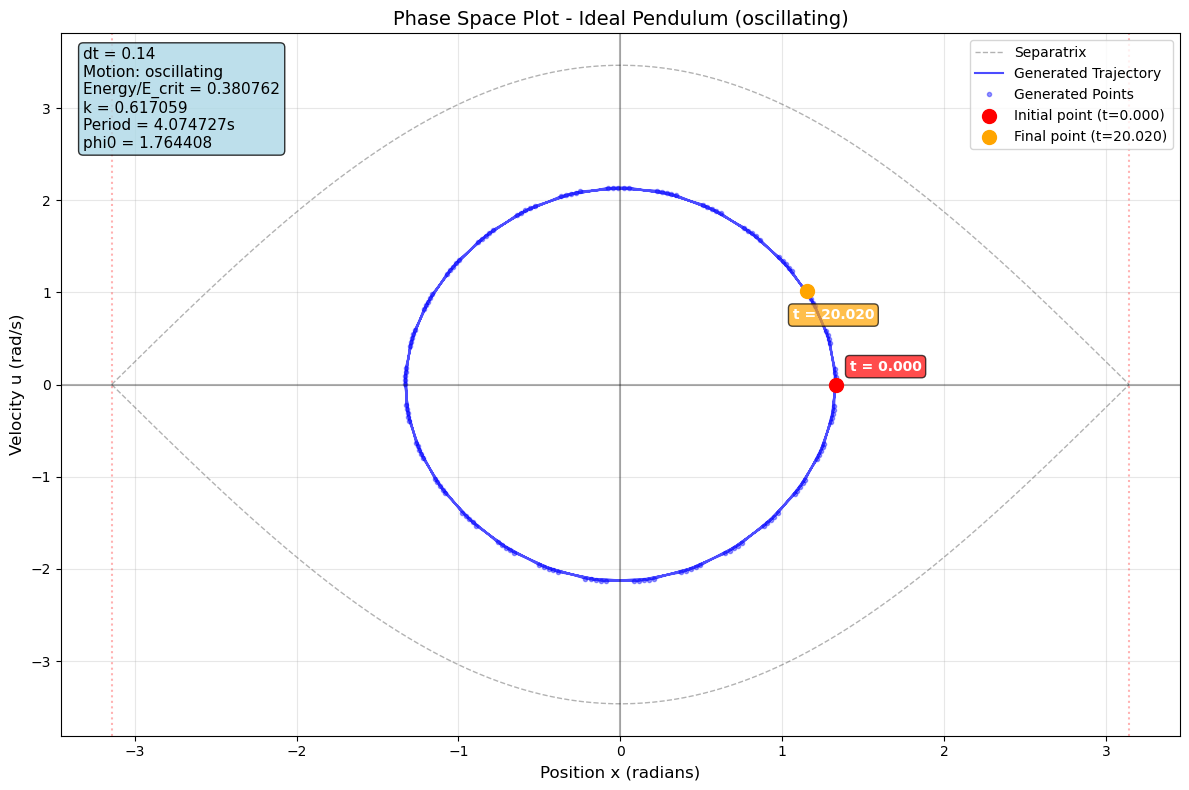

In [81]:
pendulum_test.plot_points()

In [83]:
def motion_type_percentages_str(df):
    """
    Returns motion_type percentages as a single-line formatted string.
    Example: "oscillating: 65.33%, rotating: 34.67%"
    """
    if 'motion_type' not in df.columns:
        raise ValueError("The DataFrame must contain a 'motion_type' column.")
    total = len(df)
    if total == 0:
        return "No data."
    percentages = df['motion_type'].value_counts(normalize=True) * 100
    # Join them in one line, separated by commas
    return ", ".join(f"{m}: {p:.2f}%" for m, p in percentages.items())


Generated a total of 2250 points


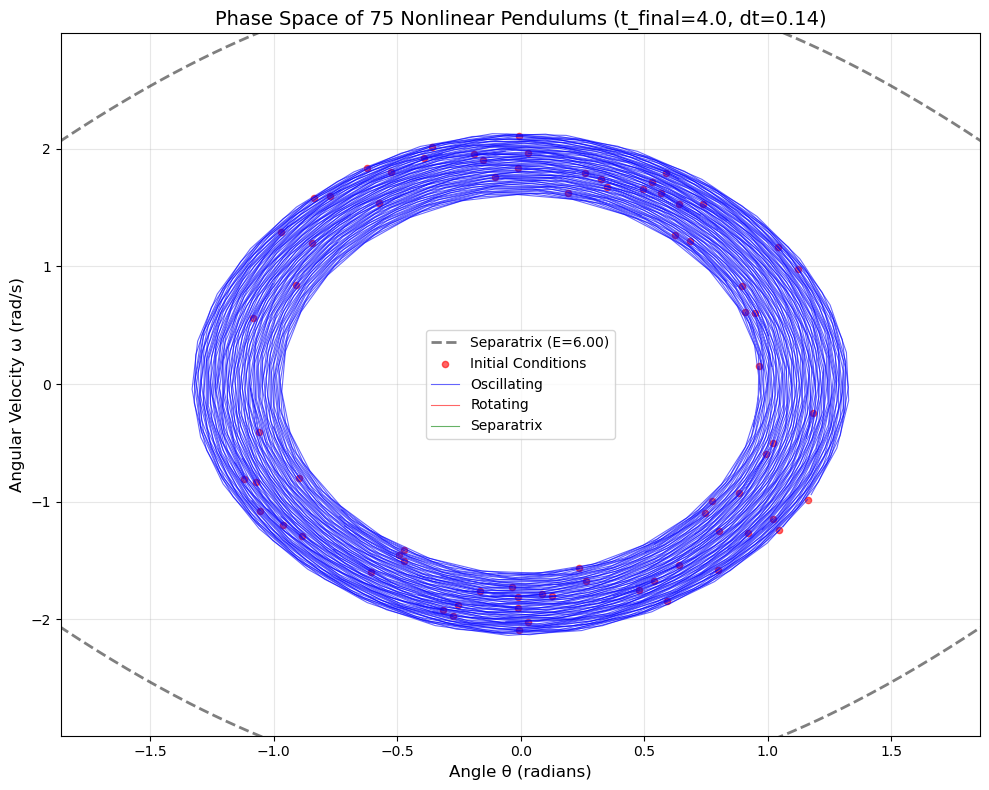

In [21]:



phase_space_low_samples_pendulum = PendulumPhaseSpace(g=3.0, length=1.0)


phase_space_low_samples_pendulum.make_oscillators(
    n_oscillators=75,
    max_x0=np.pi,
    max_u0=4,
    method='stratified_energies',
    energy_min=1.3,
    max_energy=2.3
)

# 3. Generate trajectories
phase_space_low_samples_pendulum.generate_all_oscillators_points(t_final=4.0, dt=0.14)



# 5. Visualize
phase_space_low_samples_pendulum.plot_phase_space(
    show_generated=True,
    show_separatrix=True
)

# 6. Export data
data_df_low_samples_pendulum = phase_space_low_samples_pendulum.make_trajectories_df()
id_df_low_samples_pendulum = phase_space_low_samples_pendulum.make_trajectories_ids_df()

In [22]:
df = id_df_low_samples_pendulum

total_samples = df['generated_points'].sum()
num_traj = df.shape[0]
points_per_traj = df['generated_points'].iloc[0]
min_energy = df['energy'].min()
max_energy = df['energy'].max()
energy_interval = df['energy'].iloc[1] - df['energy'].iloc[0]
percentages = motion_type_percentages_str(df)

osc_period_min = df.loc[df['motion_type'] == "oscillating", 'period'].min()
osc_period_max = df.loc[df['motion_type'] == "oscillating", 'period'].max()

print(
    f"Generated a total of {total_samples} samples\n"
    f"That data is split between {num_traj} trajectories with {points_per_traj} point each.\n"
    f"The minimum energy is {min_energy:.3f} and the maximum energy is {max_energy:.3f} "
    f"with energy interval of {energy_interval:.3f}\n"
    f"That gives the following percentages of motion types {percentages}\n"
    f"Of the trajectories that are oscillating the minimum period is: {osc_period_min:.3f} "
    f"and the max is: {osc_period_max:.3f}"
)



Generated a total of 2250 samples
That data is split between 75 trajectories with 30 point each.
The minimum energy is 1.300 and the maximum energy is 2.287 with energy interval of 0.013
That gives the following percentages of motion types oscillating: 100.00%
Of the trajectories that are oscillating the minimum period is: 3.852 and the max is: 4.075


In [23]:
train_df_low_samples_pendulum, val_df_low_samples_pendulum, test_df_low_samples_pendulum, train_id_df_low_samples_pendulum, val_id_df_low_samples_pendulum, test_id_df_low_samples_pendulum = split_trajectories(ids_df=id_df_low_samples_pendulum, full_df=data_df_low_samples_pendulum, val_pct=0.33, test_pct=0.33, random_state=42, bins=11)

In [24]:
print(f"We have {train_df_low_samples_pendulum.shape[0]} training samples among {train_id_df_low_samples_pendulum.shape[0]} trajectories with a mean energy of {train_id_df_low_samples_pendulum['energy'].mean():.3f}±{train_id_df_low_samples_pendulum['energy'].std():.3f}\nThen we have {val_df_low_samples_pendulum.shape[0]} validation samples among {val_id_df_low_samples_pendulum.shape[0]} trajectories with a mean energy of {val_id_df_low_samples_pendulum['energy'].mean():.3f}±{val_id_df_low_samples_pendulum['energy'].std():.3f}\nAnd finally we have {test_df_low_samples_pendulum.shape[0]} testing samples among {test_id_df_low_samples_pendulum.shape[0]} trajectories with a mean energy of {test_id_df_low_samples_pendulum['energy'].mean():.3f}±{test_id_df_low_samples_pendulum['energy'].std():.3f}\nAll trajectories have {train_id_df_low_samples_pendulum['generated_points'][0]} points each")
 

We have 750 training samples among 25 trajectories with a mean energy of 1.777±0.310
Then we have 750 validation samples among 25 trajectories with a mean energy of 1.804±0.296
And finally we have 750 testing samples among 25 trajectories with a mean energy of 1.799±0.276
All trajectories have 30 points each


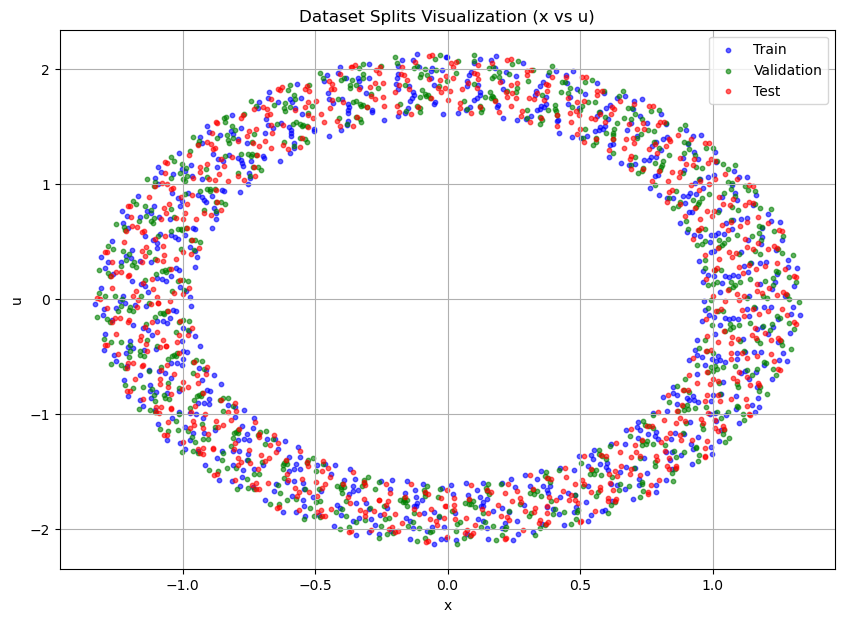

In [25]:
plt.figure(figsize=(10, 7))

plt.scatter(train_df_low_samples_pendulum['x'], train_df_low_samples_pendulum['u'], color='blue', label='Train', alpha=0.6, s=10)
plt.scatter(val_df_low_samples_pendulum['x'], val_df_low_samples_pendulum['u'], color='green', label='Validation', alpha=0.6, s=10)
plt.scatter(test_df_low_samples_pendulum['x'], test_df_low_samples_pendulum['u'], color='red', label='Test', alpha=0.6, s=10)

plt.xlabel('x')
plt.ylabel('u')
plt.title('Dataset Splits Visualization (x vs u)')
plt.legend()
plt.grid(True)
plt.show()

In [26]:


# Put all DataFrames into a dictionary
dfs_low_samples_pendulum = {
    "data_df_low_samples_pendulum": data_df_low_samples_pendulum,
    "id_df_low_samples_pendulum": id_df_low_samples_pendulum,
    "train_df_low_samples_pendulum": train_df_low_samples_pendulum,
    "val_df_low_samples_pendulum": val_df_low_samples_pendulum,
    "test_df_low_samples_pendulum": test_df_low_samples_pendulum,
    "train_id_df_low_samples_pendulum": train_id_df_low_samples_pendulum,
    "val_id_df_low_samples_pendulum": val_id_df_low_samples_pendulum,
    "test_id_df_low_samples_pendulum": test_id_df_low_samples_pendulum,
}

# Save everything in one file
with open("all_dataframes_low_samples_pendulum.pkl", "wb") as f:
    pickle.dump(dfs_low_samples_pendulum, f)

print("✅ All DataFrames saved to all_dataframes_low_samples_pendulum.pkl")




✅ All DataFrames saved to all_dataframes_low_samples_pendulum.pkl


PALI EDW

Generated a total of 2880 points


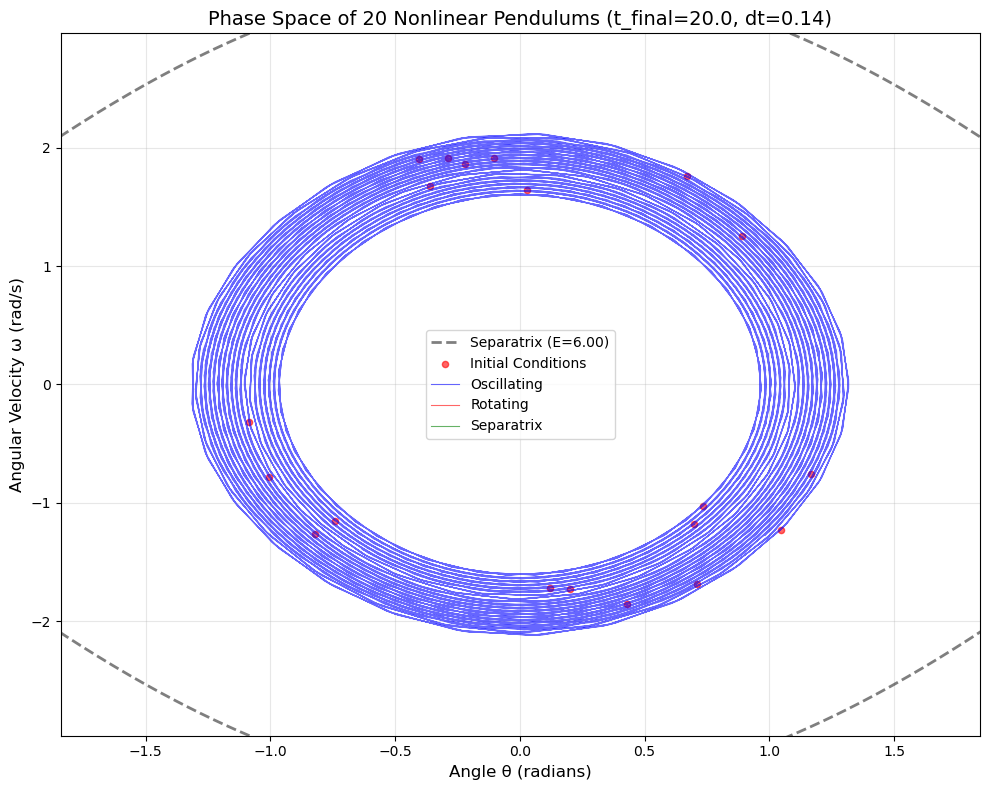

In [86]:



phase_space_low_samples_multiple_periods_pendulum = PendulumPhaseSpace(g=3.0, length=1.0)


phase_space_low_samples_multiple_periods_pendulum.make_oscillators(
    n_oscillators=20,
    max_x0=np.pi,
    max_u0=4,
    method='stratified_energies',
    energy_min=1.3,
    max_energy=2.3
)

# 3. Generate trajectories
phase_space_low_samples_multiple_periods_pendulum.generate_all_oscillators_points(t_final=20.0, dt=0.14)



# 5. Visualize
phase_space_low_samples_multiple_periods_pendulum.plot_phase_space(
    show_generated=True,
    show_separatrix=True
)

# 6. Export data
data_df_low_samples_multiple_periods_pendulum = phase_space_low_samples_multiple_periods_pendulum.make_trajectories_df()
id_df_low_samples_multiple_periods_pendulum = phase_space_low_samples_multiple_periods_pendulum.make_trajectories_ids_df()

In [87]:
df = id_df_low_samples_multiple_periods_pendulum

total_samples = df['generated_points'].sum()
num_traj = df.shape[0]
points_per_traj = df['generated_points'].iloc[0]
min_energy = df['energy'].min()
max_energy = df['energy'].max()
energy_interval = df['energy'].iloc[1] - df['energy'].iloc[0]
percentages = motion_type_percentages_str(df)

osc_period_min = df.loc[df['motion_type'] == "oscillating", 'period'].min()
osc_period_max = df.loc[df['motion_type'] == "oscillating", 'period'].max()

print(
    f"Generated a total of {total_samples} samples\n"
    f"That data is split between {num_traj} trajectories with {points_per_traj} point each.\n"
    f"The minimum energy is {min_energy:.3f} and the maximum energy is {max_energy:.3f} "
    f"with energy interval of {energy_interval:.3f}\n"
    f"That gives the following percentages of motion types {percentages}\n"
    f"Of the trajectories that are oscillating the minimum period is: {osc_period_min:.3f} "
    f"and the max is: {osc_period_max:.3f}"
)



Generated a total of 2880 samples
That data is split between 20 trajectories with 144 point each.
The minimum energy is 1.300 and the maximum energy is 2.250 with energy interval of 0.050
That gives the following percentages of motion types oscillating: 100.00%
Of the trajectories that are oscillating the minimum period is: 3.852 and the max is: 4.066


In [88]:


# Put all DataFrames into a dictionary
dfs_low_samples_multiple_periods_pendulum = {
    "data_df_low_samples_multiple_periods_pendulum": data_df_low_samples_multiple_periods_pendulum,
    "id_df_low_samples_multiple_periods_pendulum": id_df_low_samples_multiple_periods_pendulum,
}

# Save everything in one file
with open("all_dataframes_low_samples_multiple_periods_pendulum.pkl", "wb") as f:
    pickle.dump(dfs_low_samples_multiple_periods_pendulum, f)

print("✅ All DataFrames saved to all_dataframes_low_samples_multiple_periods_pendulum.pkl")




✅ All DataFrames saved to all_dataframes_low_samples_multiple_periods_pendulum.pkl


PALI MEXRI EDW

Generated a total of 962 points


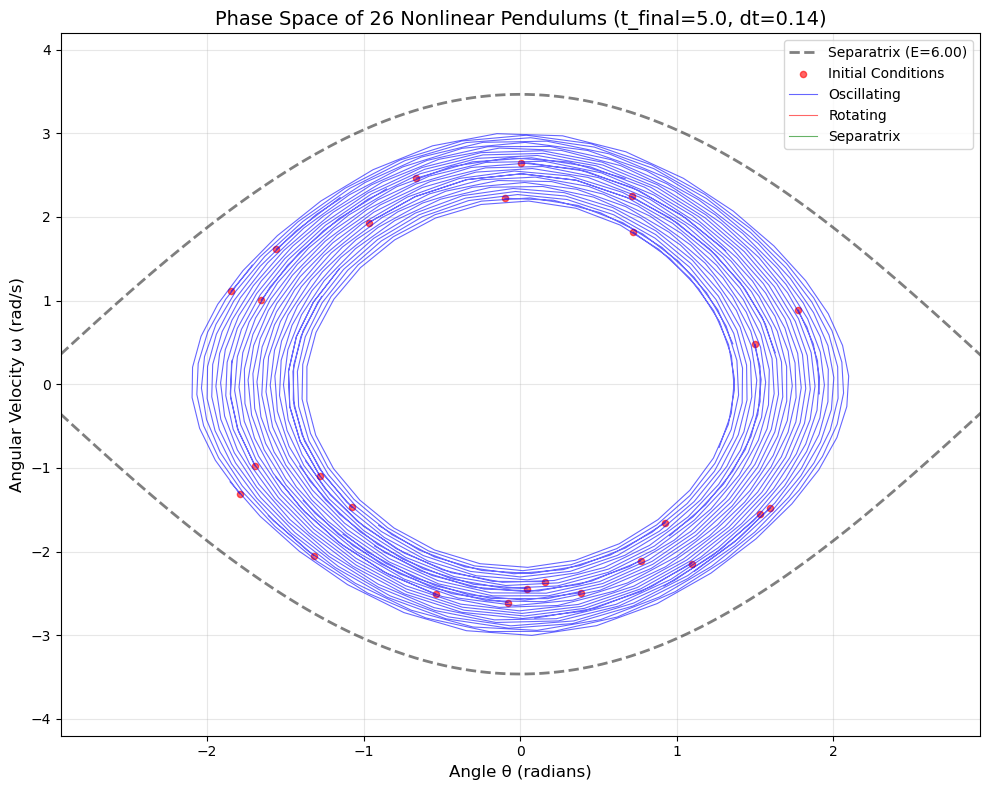

In [27]:



phase_space_low_samples_high_energy_pendulum = PendulumPhaseSpace(g=3.0, length=1.0)


phase_space_low_samples_high_energy_pendulum.make_oscillators(
    n_oscillators=26,
    max_x0=np.pi,
    max_u0=4,
    method='stratified_energies',
    energy_min=2.4,
    max_energy=4.6
)

# 3. Generate trajectories
phase_space_low_samples_high_energy_pendulum.generate_all_oscillators_points(t_final=5.0, dt=0.14)



# 5. Visualize
phase_space_low_samples_high_energy_pendulum.plot_phase_space(
    show_generated=True,
    show_separatrix=True
)

# 6. Export data
data_df_low_samples_high_energy_pendulum = phase_space_low_samples_high_energy_pendulum.make_trajectories_df()
id_df_low_samples_high_energy_pendulum = phase_space_low_samples_high_energy_pendulum.make_trajectories_ids_df()

In [36]:
df = id_df_low_samples_high_energy_pendulum

total_samples = df['generated_points'].sum()
num_traj = df.shape[0]
points_per_traj = df['generated_points'].iloc[0]
min_energy = df['energy'].min()
max_energy = df['energy'].max()
energy_interval = df['energy'].iloc[1] - df['energy'].iloc[0]
percentages = motion_type_percentages_str(df)

osc_period_min = df.loc[df['motion_type'] == "oscillating", 'period'].min()
osc_period_max = df.loc[df['motion_type'] == "oscillating", 'period'].max()

print(
    f"Generated a total of {total_samples} samples\n"
    f"That data is split between {num_traj} trajectories with {points_per_traj} point each.\n"
    f"The minimum energy is {min_energy:.3f} and the maximum energy is {max_energy:.3f} "
    f"with energy interval of {energy_interval:.3f}\n"
    f"That gives the following percentages of motion types {percentages}\n"
    f"Of the trajectories that are oscillating the minimum period is: {osc_period_min:.3f} "
    f"and the max is: {osc_period_max:.3f}"
)



Generated a total of 962 samples
That data is split between 26 trajectories with 37 point each.
The minimum energy is 2.400 and the maximum energy is 4.515 with energy interval of 0.085
That gives the following percentages of motion types oscillating: 100.00%
Of the trajectories that are oscillating the minimum period is: 4.105 and the max is: 4.991


In [39]:
val_df_high_energy_low_samples_pendulum, test_df_high_energy_low_samples_pendulum, val_id_df_high_energy_low_samples_pendulum, test_id_df_high_energy_low_samples_pendulum = split_trajectories_only_val(id_df_low_samples_high_energy_pendulum, data_df_low_samples_high_energy_pendulum, test_pct=0.5, random_state=42, bins=10)

In [40]:
print(f"Then we have {val_df_high_energy_low_samples_pendulum.shape[0]} validation samples among {val_id_df_high_energy_low_samples_pendulum.shape[0]} trajectories with a mean energy of {val_id_df_high_energy_low_samples_pendulum['energy'].mean():.3f}±{val_id_df_high_energy_low_samples_pendulum['energy'].std():.3f}\nAnd finally we have {test_df_high_energy_low_samples_pendulum.shape[0]} testing samples among {test_id_df_high_energy_low_samples_pendulum.shape[0]} trajectories with a mean energy of {test_id_df_high_energy_low_samples_pendulum['energy'].mean():.3f}±{test_id_df_high_energy_low_samples_pendulum['energy'].std():.3f}\nAll trajectories have {test_id_df_high_energy_low_samples_pendulum['generated_points'][0]} points each")
 

Then we have 481 validation samples among 13 trajectories with a mean energy of 3.422±0.713
And finally we have 481 testing samples among 13 trajectories with a mean energy of 3.493±0.602
All trajectories have 37 points each


In [41]:
dfs_high_energy_low_samples_pendulum = {

    "val_df_high_energy_low_samples_pendulum": val_df_high_energy_low_samples_pendulum,
    "test_df_high_energy_low_samples_pendulum": test_df_high_energy_low_samples_pendulum,
    "val_id_df_high_energy_low_samples_pendulum": val_id_df_high_energy_low_samples_pendulum,
    "test_id_df_high_energy_low_samples_pendulum": test_id_df_high_energy_low_samples_pendulum,

}

# Save everything in one file
with open("df_high_energy_low_samples_pendulum.pkl", "wb") as f:
    pickle.dump(dfs_high_energy_low_samples_pendulum, f)

print("✅ All DataFrames saved to df_high_energy_low_samples_pendulum.pkl")

✅ All DataFrames saved to df_high_energy_low_samples_pendulum.pkl


Generated a total of 29282 points


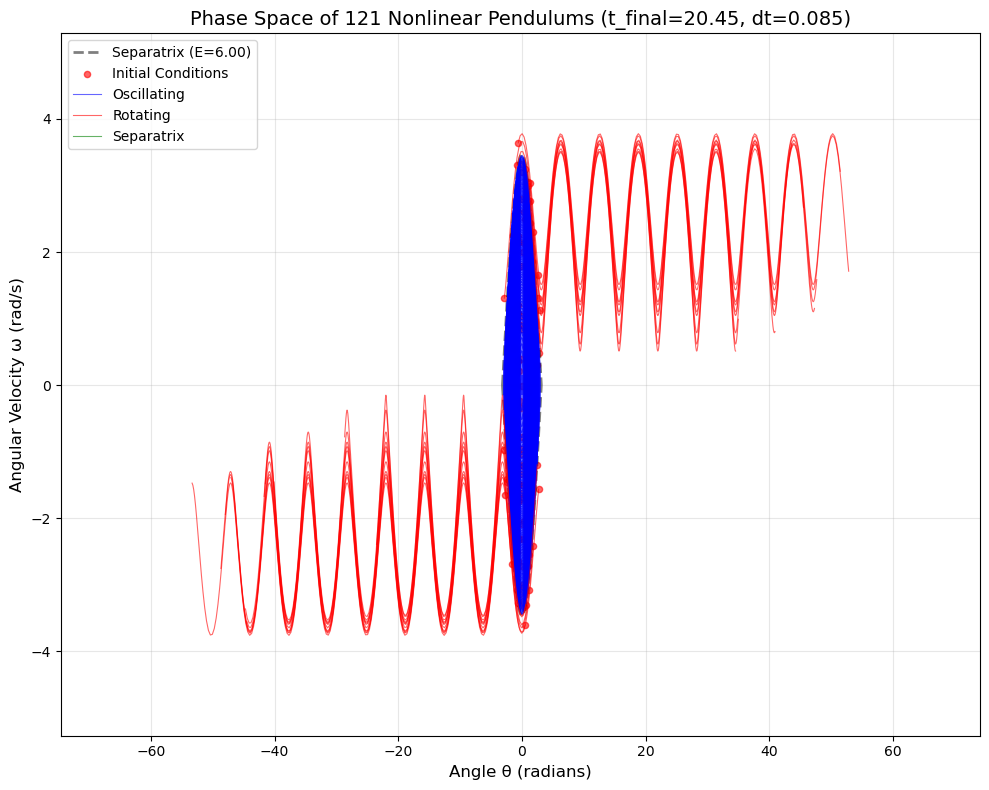

In [41]:



phase_space_pendulum = PendulumPhaseSpace(g=3.0, length=1.0)


phase_space_pendulum.make_oscillators(
    n_oscillators=121,
    max_x0=np.pi,
    max_u0=15,
    method='stratified_energies',
    energy_min=0.01,
    max_energy=7.2
)

# 3. Generate trajectories
phase_space_pendulum.generate_all_oscillators_points(t_final=20.45, dt=0.085)

#20.45

# 5. Visualize
phase_space_pendulum.plot_phase_space(
    show_generated=True,
    show_separatrix=True
)

# 6. Export data
data_df_pendulum = phase_space_pendulum.make_trajectories_df()
id_df_pendulum = phase_space_pendulum.make_trajectories_ids_df()

In [42]:
df = id_df_pendulum

total_samples = df['generated_points'].sum()
num_traj = df.shape[0]
points_per_traj = df['generated_points'].iloc[0]
min_energy = df['energy'].min()
max_energy = df['energy'].max()
energy_interval = df['energy'].iloc[1] - df['energy'].iloc[0]
percentages = motion_type_percentages_str(df)

osc_period_min = df.loc[df['motion_type'] == "oscillating", 'period'].min()
osc_period_max = df.loc[df['motion_type'] == "oscillating", 'period'].max()

print(
    f"Generated a total of {total_samples} samples\n"
    f"That data is split between {num_traj} trajectories with {points_per_traj} point each.\n"
    f"The minimum energy is {min_energy:.3f} and the maximum energy is {max_energy:.3f} "
    f"with energy interval of {energy_interval:.3f}\n"
    f"That gives the following percentages of motion types {percentages}\n"
    f"Of the trajectories that are oscillating the minimum period is: {osc_period_min:.3f} "
    f"and the max is: {osc_period_max:.3f}"
)



Generated a total of 29282 samples
That data is split between 121 trajectories with 242 point each.
The minimum energy is 0.010 and the maximum energy is 7.141 with energy interval of 0.059
That gives the following percentages of motion types oscillating: 83.47%, rotating: 16.53%
Of the trajectories that are oscillating the minimum period is: 3.629 and the max is: 8.793


In [66]:
train_df_pendulum, val_df_pendulum, test_df_pendulum, train_id_df_pendulum, val_id_df_pendulum, test_id_df_pendulum = split_trajectories(ids_df=id_df_pendulum, full_df=data_df_pendulum, val_pct=0.095, test_pct=0.095, random_state=47, bins=11)

In [67]:
print(f"We have {train_df_pendulum.shape[0]} training samples among {train_id_df_pendulum.shape[0]} trajectories with a mean energy of {train_id_df_pendulum['energy'].mean():.3f}±{train_id_df_pendulum['energy'].std():.3f}\nThen we have {val_df_pendulum.shape[0]} validation samples among {val_id_df_pendulum.shape[0]} trajectories with a mean energy of {val_id_df_pendulum['energy'].mean():.3f}±{val_id_df_pendulum['energy'].std():.3f}\nAnd finally we have {test_df_pendulum.shape[0]} testing samples among {test_id_df_pendulum.shape[0]} trajectories with a mean energy of {test_id_df_pendulum['energy'].mean():.3f}±{test_id_df_pendulum['energy'].std():.3f}\nAll trajectories have {train_id_df_pendulum['generated_points'][0]} points each")
 

We have 23474 training samples among 97 trajectories with a mean energy of 3.528±2.089
Then we have 2904 validation samples among 12 trajectories with a mean energy of 3.778±2.123
And finally we have 2904 testing samples among 12 trajectories with a mean energy of 3.759±2.165
All trajectories have 242 points each


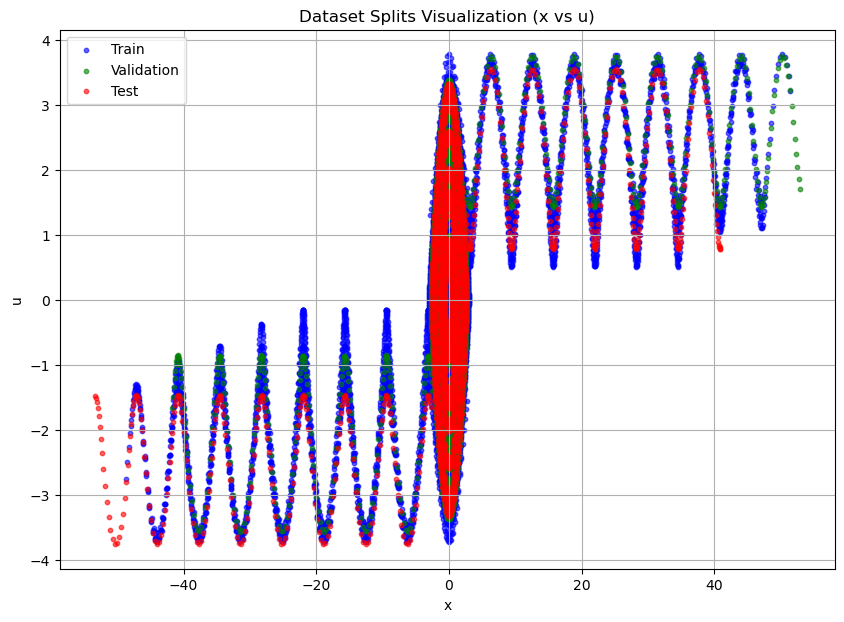

In [70]:
plt.figure(figsize=(10, 7))

plt.scatter(train_df_pendulum['x'], train_df_pendulum['u'], color='blue', label='Train', alpha=0.6, s=10)
plt.scatter(val_df_pendulum['x'], val_df_pendulum['u'], color='green', label='Validation', alpha=0.6, s=10)
plt.scatter(test_df_pendulum['x'], test_df_pendulum['u'], color='red', label='Test', alpha=0.6, s=10)

plt.xlabel('x')
plt.ylabel('u')
plt.title('Dataset Splits Visualization (x vs u)')
plt.legend()
plt.grid(True)
plt.show()

In [71]:


# Put all DataFrames into a dictionary
dfs_pendulum = {
    "data_df_pendulum": data_df_pendulum,
    "id_df_pendulum": id_df_pendulum,
    "train_df_pendulum": train_df_pendulum,
    "val_df_pendulum": val_df_pendulum,
    "test_df_pendulum": test_df_pendulum,
    "train_id_df_pendulum": train_id_df_pendulum,
    "val_id_df_pendulum": val_id_df_pendulum,
    "test_id_df_pendulum": test_id_df_pendulum,
}

# Save everything in one file
with open("all_dataframes_pendulum.pkl", "wb") as f:
    pickle.dump(dfs_pendulum, f)

print("✅ All DataFrames saved to all_dataframes_pendulum.pkl")




✅ All DataFrames saved to all_dataframes_pendulum.pkl


Generated a total of 1728 points


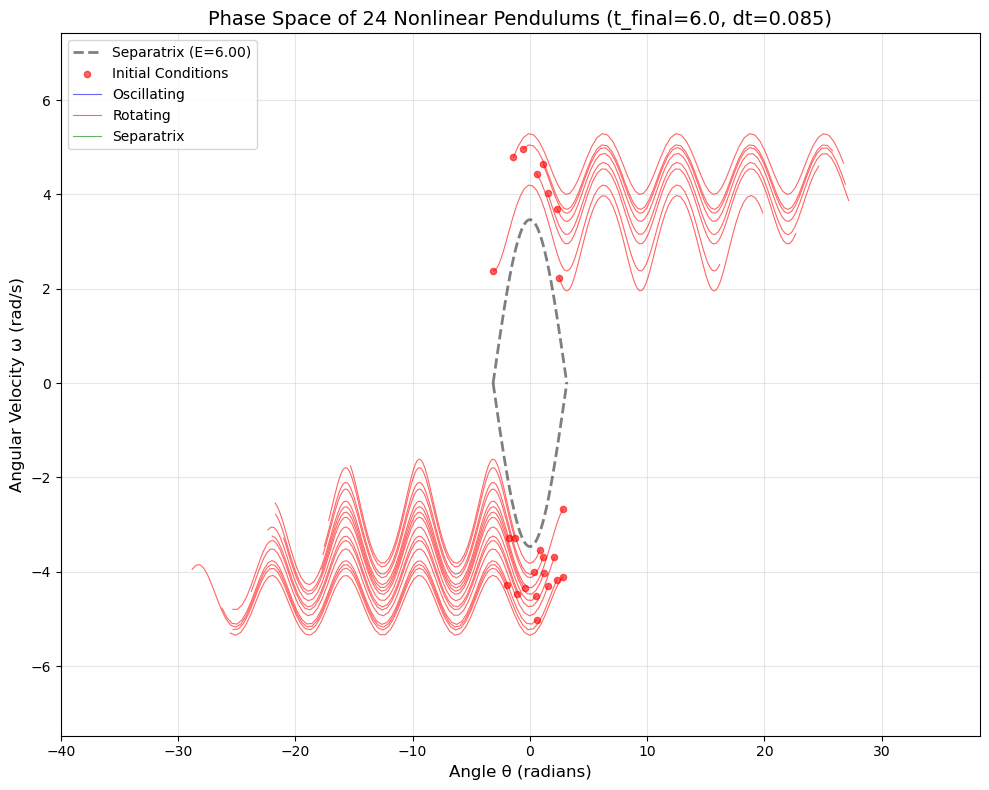

In [90]:



phase_space_high_energy_pendulum = PendulumPhaseSpace(g=3.0, length=1.0)


phase_space_high_energy_pendulum.make_oscillators(
    n_oscillators=24,
    max_x0=np.pi,
    max_u0=7.0,
    method='stratified_energies',
    energy_min=7.3,
    max_energy=14.6
)

# 3. Generate trajectories
phase_space_high_energy_pendulum.generate_all_oscillators_points(t_final=6.0, dt=0.085)



# 5. Visualize
phase_space_high_energy_pendulum.plot_phase_space(
    show_generated=True,
    show_separatrix=True
)

# 6. Export data
data_df_high_energy_pendulum = phase_space_high_energy_pendulum.make_trajectories_df()
id_df_high_energy_pendulum = phase_space_high_energy_pendulum.make_trajectories_ids_df()

In [101]:
df = id_df_high_energy_pendulum

total_samples = df['generated_points'].sum()
num_traj = df.shape[0]
points_per_traj = df['generated_points'].iloc[0]
min_energy = df['energy'].min()
max_energy = df['energy'].max()
energy_interval = df['energy'].iloc[1] - df['energy'].iloc[0]
percentages = motion_type_percentages_str(df)

osc_period_min = df.loc[df['motion_type'] == "oscillating", 'period'].min()
osc_period_max = df.loc[df['motion_type'] == "oscillating", 'period'].max()

print(
    f"Generated a total of {total_samples} samples\n"
    f"That data is split between {num_traj} trajectories with {points_per_traj} point each.\n"
    f"The minimum energy is {min_energy:.3f} and the maximum energy is {max_energy:.3f} "
    f"with energy interval of {energy_interval:.3f}\n"
    f"That gives the following percentages of motion types {percentages}\n"
    f"Of the trajectories that are oscillating the minimum period is: {osc_period_min:.3f} "
    f"and the max is: {osc_period_max:.3f}"
)



Generated a total of 1728 samples
That data is split between 24 trajectories with 72 point each.
The minimum energy is 7.300 and the maximum energy is 14.296 with energy interval of 0.304
That gives the following percentages of motion types rotating: 100.00%
Of the trajectories that are oscillating the minimum period is: nan and the max is: nan


In [102]:
val_df_high_energy_pendulum, test_df_high_energy_pendulum, val_id_df_high_energy_pendulum, test_id_df_high_energy_pendulum = split_trajectories_only_val(id_df_high_energy_pendulum, data_df_high_energy_pendulum, test_pct=0.5, random_state=42, bins=10)

In [103]:
print(f"Then we have {val_df_high_energy_pendulum.shape[0]} validation samples among {val_id_df_high_energy_pendulum.shape[0]} trajectories with a mean energy of {val_id_df_high_energy_pendulum['energy'].mean():.3f}±{val_id_df_high_energy_pendulum['energy'].std():.3f}\nAnd finally we have {test_df_high_energy_pendulum.shape[0]} testing samples among {test_id_df_high_energy_pendulum.shape[0]} trajectories with a mean energy of {test_id_df_high_energy_pendulum['energy'].mean():.3f}±{test_id_df_high_energy_pendulum['energy'].std():.3f}\nAll trajectories have {test_id_df_high_energy_pendulum['generated_points'].iloc[0]} points each")

Then we have 864 validation samples among 12 trajectories with a mean energy of 10.950±2.182
And finally we have 864 testing samples among 12 trajectories with a mean energy of 10.646±2.205
All trajectories have 72 points each


In [104]:
dfs_high_energy_pendulum = {

    "val_df_high_energy_pendulum": val_df_high_energy_pendulum,
    "test_df_high_energy_pendulum": test_df_high_energy_pendulum,
    "val_id_df_high_energy_pendulum": val_id_df_high_energy_pendulum,
    "test_id_df_high_energy_pendulum": test_id_df_high_energy_pendulum,

}

# Save everything in one file
with open("df_high_energy_pendulum.pkl", "wb") as f:
    pickle.dump(dfs_high_energy_pendulum, f)

print("✅ All DataFrames saved to df_high_energy_pendulum.pkl")

✅ All DataFrames saved to df_high_energy_pendulum.pkl


In [2]:

import zipfile


def get_pendulum_dataframe(zip_path='./invar_datasets.zip'):
    with zipfile.ZipFile(zip_path, 'r') as z:
        with z.open('real_pend_h_1.txt') as f:
            df = pd.read_csv(f, sep='\s+', header=None, comment='%')
    df.columns = ['zeros', 't', 'theta', 'omega']
    return df


# Load the data
df_real_pendulum = get_pendulum_dataframe()



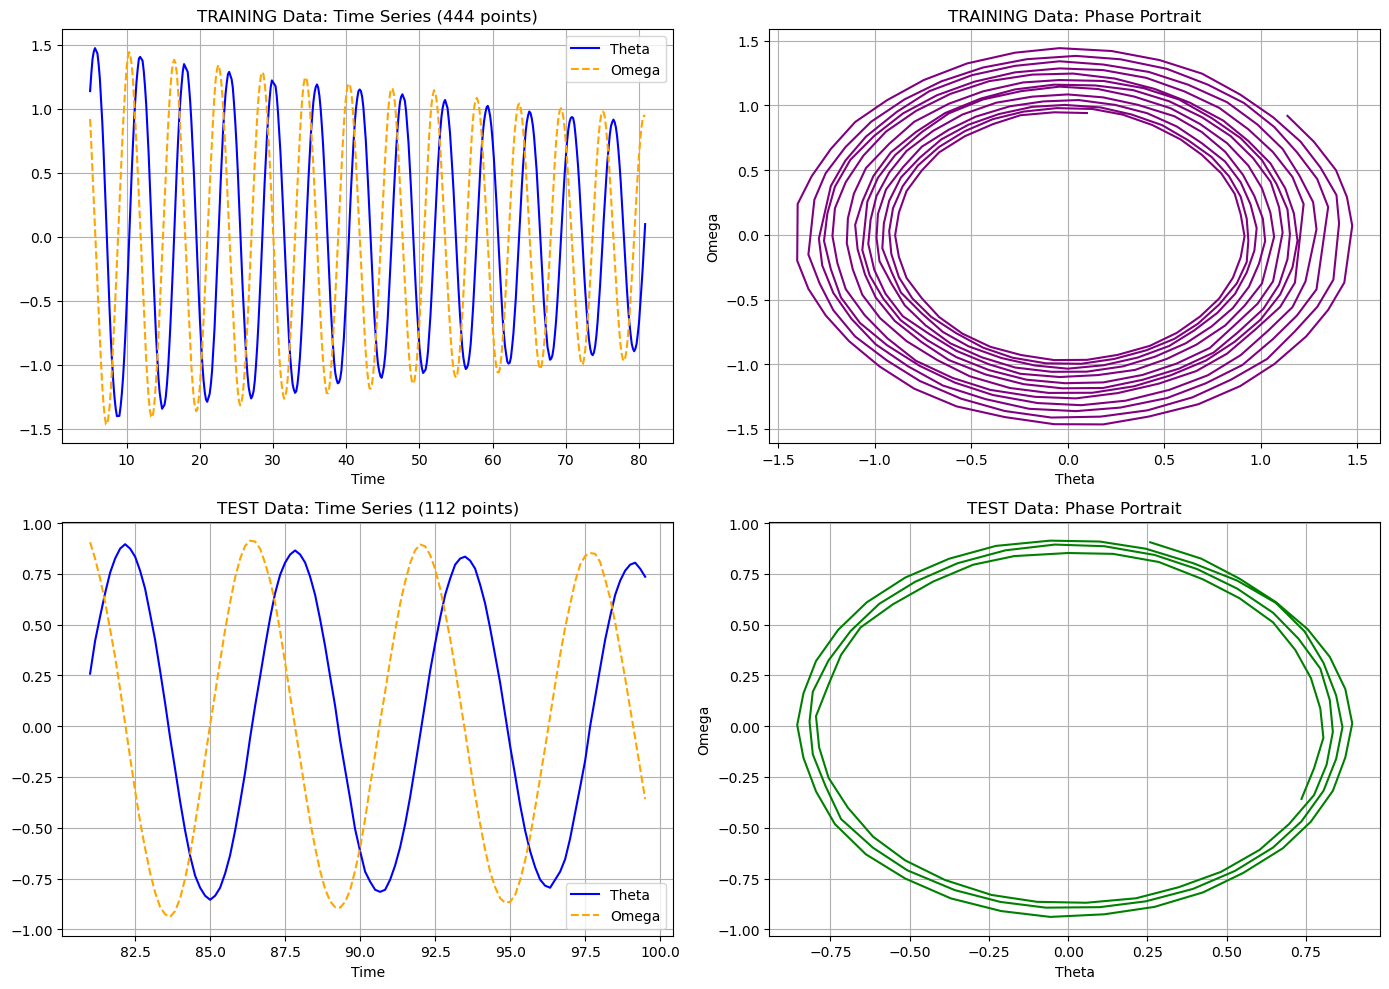

In [4]:
split_ratio = 0.8
train_size = int(len(df_real_pendulum) * split_ratio)

train_df_real_pendulum = df_real_pendulum.iloc[:train_size]
test_df_real_pendulum = df_real_pendulum.iloc[train_size:]

# 3. Create 4 Plots (2x2 Grid)
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# --- ROW 1: TRAINING DATA ---
# Time Series
ax[0,0].plot(train_df_real_pendulum['t'], train_df_real_pendulum['theta'], label='Theta', color='blue')
ax[0,0].plot(train_df_real_pendulum['t'], train_df_real_pendulum['omega'], label='Omega', color='orange', linestyle='--')
ax[0,0].set_title(f'TRAINING Data: Time Series ({len(train_df_real_pendulum)} points)')
ax[0,0].set_xlabel('Time')
ax[0,0].legend()
ax[0,0].grid(True)

# Phase Portrait
ax[0,1].plot(train_df_real_pendulum['theta'], train_df_real_pendulum['omega'], color='purple')
ax[0,1].set_title('TRAINING Data: Phase Portrait')
ax[0,1].set_xlabel('Theta')
ax[0,1].set_ylabel('Omega')
ax[0,1].grid(True)

# --- ROW 2: TEST DATA ---
# Time Series
ax[1,0].plot(test_df_real_pendulum['t'], test_df_real_pendulum['theta'], label='Theta', color='blue')
ax[1,0].plot(test_df_real_pendulum['t'], test_df_real_pendulum['omega'], label='Omega', color='orange', linestyle='--')
ax[1,0].set_title(f'TEST Data: Time Series ({len(test_df_real_pendulum)} points)')
ax[1,0].set_xlabel('Time')
ax[1,0].legend()
ax[1,0].grid(True)

# Phase Portrait
ax[1,1].plot(test_df_real_pendulum['theta'], test_df_real_pendulum['omega'], color='green')
ax[1,1].set_title('TEST Data: Phase Portrait')
ax[1,1].set_xlabel('Theta')
ax[1,1].set_ylabel('Omega')
ax[1,1].grid(True)

plt.tight_layout()
plt.show()

In [140]:
train_df_real_pendulum = (train_df_real_pendulum.drop('zeros', axis=1)
            .rename(columns={'theta': 'x', 'omega': 'u'})
            .assign(t=lambda df_real_pendulum: df_real_pendulum['t'] - df_real_pendulum['t'].iloc[0])
            [['x', 'u', 't']])

test_df_real_pendulum = (test_df_real_pendulum.drop('zeros', axis=1)
           .rename(columns={'theta': 'x', 'omega': 'u'})
           .assign(t=lambda df_real_pendulum: df_real_pendulum['t'] - df_real_pendulum['t'].iloc[0])
           [['x', 'u', 't']])

In [141]:

train_id_df_real_pendulum = pd.DataFrame({
    'trajectory_id': [1],
    'x0': [train_df_real_pendulum['x'].iloc[0]],
    'u0': [train_df_real_pendulum['u'].iloc[0]],
    'generated_points': [len(train_df_real_pendulum)],
    'start_index': [train_df_real_pendulum.index[0]],
    'end_index': [train_df_real_pendulum.index[-1]],
    'energy': [0.0]
})

test_id_df_real_pendulum = pd.DataFrame({
    'trajectory_id': [1],
    'x0': [test_df_real_pendulum['x'].iloc[0]],
    'u0': [test_df_real_pendulum['u'].iloc[0]],
    'generated_points': [len(test_df_real_pendulum)],
    'start_index': [test_df_real_pendulum.index[0]],
    'end_index': [test_df_real_pendulum.index[-1]],
    'energy': [0.0]
})

In [146]:


# Put all DataFrames into a dictionary
dfs_real_pendulum = {

    "train_df_real_pendulum": train_df_real_pendulum,
    "test_df_real_pendulum": test_df_real_pendulum,
    
    "train_id_df_real_pendulum": train_id_df_real_pendulum,
    "test_id_df_real_pendulum": test_id_df_real_pendulum,
}

# Save everything in one file
with open("all_dataframes_real_pendulum.pkl", "wb") as f:
    pickle.dump(dfs_real_pendulum, f)

print("✅ All DataFrames saved to all_dataframes_real_pendulum.pkl")




✅ All DataFrames saved to all_dataframes_real_pendulum.pkl


In [29]:
train_df_real_pendulum = (train_df_real_pendulum.drop('zeros', axis=1)
                          .rename(columns={'theta': 'x', 'omega': 'u'})
                          [['x', 'u', 't']])

# Create trajectory IDs (every 37 rows)
train_trajectory_ids = np.arange(len(train_df_real_pendulum)) // 37

# Reset time to 0 for each trajectory
train_df_real_pendulum['t'] = train_df_real_pendulum.groupby(train_trajectory_ids)['t'].transform(
    lambda x: x - x.iloc[0]
)

# Create metadata dataframe for train
train_metadata_list = []
for traj_id in np.unique(train_trajectory_ids):
    mask = train_trajectory_ids == traj_id
    group = train_df_real_pendulum[mask]
    train_metadata_list.append({
        'trajectory_id': traj_id,
        'x0': group['x'].iloc[0],
        'u0': group['u'].iloc[0],
        'generated_points': len(group),
        'start_index': group.index[0],
        'end_index': group.index[-1],
        'energy': 0.0
    })

train_id_df_real_pendulum = pd.DataFrame(train_metadata_list)

# Process test_df_real_pendulum
test_df_real_pendulum = (test_df_real_pendulum.drop('zeros', axis=1)
                         .rename(columns={'theta': 'x', 'omega': 'u'})
                         [['x', 'u', 't']])

# Create trajectory IDs (every 37 rows)
test_trajectory_ids = np.arange(len(test_df_real_pendulum)) // 37

# Reset time to 0 for each trajectory
test_df_real_pendulum['t'] = test_df_real_pendulum.groupby(test_trajectory_ids)['t'].transform(
    lambda x: x - x.iloc[0]
)

# Create metadata dataframe for test
test_metadata_list = []
for traj_id in np.unique(test_trajectory_ids):
    mask = test_trajectory_ids == traj_id
    group = test_df_real_pendulum[mask]
    test_metadata_list.append({
        'trajectory_id': traj_id,
        'x0': group['x'].iloc[0],
        'u0': group['u'].iloc[0],
        'generated_points': len(group),
        'start_index': group.index[0],
        'end_index': group.index[-1],
        'energy': 0.0
    })

test_id_df_real_pendulum = pd.DataFrame(test_metadata_list)

train_id_df_real_pendulum['end_index'] = train_id_df_real_pendulum['end_index'] + 1
test_id_df_real_pendulum['end_index'] = test_id_df_real_pendulum['end_index'] + 1


In [39]:


# Put all DataFrames into a dictionary
dfs_real_pendulum_retry = {

    "train_df_real_pendulum_retry": train_df_real_pendulum,
    "test_df_real_pendulum_retry": test_df_real_pendulum,
    
    "train_id_df_real_pendulum_retry": train_id_df_real_pendulum,
    "test_id_df_real_pendulum_retry": test_id_df_real_pendulum,
}

# Save everything in one file
with open("all_dataframes_real_pendulum_retry.pkl", "wb") as f:
    pickle.dump(dfs_real_pendulum_retry, f)

print("✅ All DataFrames saved to all_dataframes_real_pendulum_retry.pkl")




✅ All DataFrames saved to all_dataframes_real_pendulum_retry.pkl
